In [225]:
import glob
import importlib
import sys, os

import numpy as np
import scipy.optimize as op
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, FormatStrFormatter)

import astropy.units as u
from itertools import cycle

import emcee
import synphot

from dust_extinction.averages import G03_SMCBar
from dust_extinction.averages import G03_LMCAvg
from dust_extinction.parameter_averages import F19

import measure_extinction
from measure_extinction.stardata import StarData
from measure_extinction.extdata import ExtData
from measure_extinction.modeldata import ModelData
from measure_extinction.utils.fit_model import FitInfo

from measure_extinction.utils.helpers import get_full_starfile
from measure_extinction.utils.fit_model import get_best_fit_params, get_percentile_params

from measure_extinction.plotting.plot_spec import plot_multi_spectra, plot_spectrum
from measure_extinction.merge_obsspec import _wavegrid
from measure_extinction.utils import scale_spex_spec
import extinction_ensemble_props

# from hst_smc_ext.utils import fit_uv_ext_fm90

file_path = "/Users/pyanchulova/Documents/extstar_data/"
savefile_path = "/Users/pyanchulova/Documents/ext-science/figs/"
folder = ""

# STIS data location
#karl_data_path = "~/../../user/kgordon/Python_git/extstar_data/STIS_Data/"

if not os.path.isdir(savefile_path + folder):
    print("making new dir", (savefile_path + folder))
    os.system("mkdir " + savefile_path + folder)

galaxy = "m31" #"m33" # "m31"
gal_str = galaxy + "_"

m31_list = [
            "m31_e1_j004354.05+412626.0",
            "m31_e2_j004413.84+414903.9", # OK fit; opt fails 50-50
            "m31_e3_j004420.52+411751.1",
            "m31_e4_j004427.47+415150.0",
            "m31_e5_j004431.66+413612.4", # So-so fit, phot issues, with F336W (excluded, fit is better)
            # "m31_e6_j004438.71+415553.5", # 4-band: remove IR photometry: F110 and F160
            "m31_e7_j004454.37+412823.9",
            "m31_e8_j004511.82+415025.3",
            "m31_e9_j004511.85+413712.9", 
            ## "m31_e10_j004512.73+413726.4", "m31_e11_j004535.40+414431.5", # No STIS data
            "m31_e12_j004539.00+415439.0",
            "m31_e13_j004539.70+415054.8",
            "m31_e14_j004543.46+414513.6",
            "m31_e15_j004546.81+415431.7",
            #"m31_e17_j003944.71+402056.2", # N filters:
            #"m31_e18_j003958.22+402329.0", # N filters:
            #"m31_e22_j004034.61+404326.1", # N filters:
            #"m31_e24_j004412.17+413324.2", # N filters:
            ]
m33_list = ["m33_e1_j013334.26+303327", 
            "m33_e2_j013339.52+304540",
            #"m33_e3_j013250.80+303507", 
            "m33_e4_j013344.59+304436", 
            #"m33_e5_j013406.63+304147", 
            #"m33_e6_j013410.59+304616", 
            "m33_e7_j012241.93+304728", 
            #"m33_e8_j013416.10+303344.9"
           ]

relband = "ACS_F475W"
relband_str = "$F475W$"
nof275w = True

# If only fitting stars with WFPC2 photometry
if len(m31_list) <= 2:
    for i in range(len(m31_list)):
        if 'e17' in m31_list[i]:
            print("e17 in m31_list")
            relband = "WFPC2_F439W"
            relband_str = "$F439W$"

for i in range(len(m31_list)):
    if 'e17' in m31_list[i] or 'e18' in m31_list[i] or 'e24' in m31_list[i]:
        print("e17 and/or e18 and/or e24 in m31_list")
        relband = "V"

velocity = -109.3 # M31 radial velocity from NED
if galaxy == 'm33':
    velocity = -179.2 # M33 radial velocity from NED
    m31_list = m33_list
else:
    velocity = -109.3 # M31 radial velocity from NED

# to test aquisition of fstarname
starname = m31_list[0]
fstarname = f"{starname}.dat"

starstr = starname.split(gal_str)[1].split("_")[0]
print("starname and starstr", starname, starstr)
fontsize=14

print("stars list:", m31_list)
print("gal_str:", gal_str)
print("relband:", relband)

rwaverange = [0.1, 0.32] * u.micron
gres = 150

starname and starstr m31_e1_j004354.05+412626.0 e1
stars list: ['m31_e1_j004354.05+412626.0', 'm31_e2_j004413.84+414903.9', 'm31_e3_j004420.52+411751.1', 'm31_e4_j004427.47+415150.0', 'm31_e5_j004431.66+413612.4', 'm31_e7_j004454.37+412823.9', 'm31_e8_j004511.82+415025.3', 'm31_e9_j004511.85+413712.9', 'm31_e12_j004539.00+415439.0', 'm31_e13_j004539.70+415054.8', 'm31_e14_j004543.46+414513.6', 'm31_e15_j004546.81+415431.7']
gal_str: m31_
relband: ACS_F475W


### Read in the star data

In [94]:
def get_red_star(fstarname, file_path, excl_zero=True, excl_wls=True, 
                 rebin=True, rbres=750, fourband=False, nof275w=True,
                 excl_ends=True, lenendremflux=1, beg_wls=[.1141, .1148], 
                 end_wls=[.3136, .3155]):
    """

    Sample call: red_star, band_names, data_names = get_red_star(fstarname, file_path)
    
    excl_wls:   list. default=False
                    exclude data in the range given by excl_wls (170-200 nm for some stars)
    beg_wls:    [.1141, .1148]
    end_wls:    [.3136, .3155]
    

    """
    # get the observed reddened star data
    reddened_star = StarData(fstarname, path=f"{file_path}/DAT_files/")
    # self.data[curtype].fluxes[self.data[curtype].npts == 0] = np.nan
    
    print("reddened_star.data.keys()", reddened_star.data.keys())
    
    # Exclude a WL range
    if excl_wls:
        print('excluding wvls')
        for curtype in reddened_star.data.keys():
            (gindxs,) = np.where(
                (reddened_star.data[curtype].waves.to(u.micron).value >= excl_wls[0])
                & (reddened_star.data[curtype].waves.to(u.micron).value <= excl_wls[1])
            )
            print('EXCLUDING WVLS')
            excl_fluxes = reddened_star.data[curtype].fluxes[gindxs]
            reddened_star.data[curtype].npts[gindxs] = 0
            # reddened_star.data[curtype].fluxes[reddened_star.data[curtype].npts == 0] = np.nan
            reddened_star.data[curtype].fluxes[gindxs] = np.nan
        
    else:
        gindxs=None
        excl_fluxes=None
        
    if excl_ends:
        print("Removing ends")
        
        # beg_fluxes = np.asarray(np.linspace(0,20, lenendremflux), dtype=int)
        # end_fluxes = np.asarray(np.linspace(-20,-1, lenendremflux), dtype=int)

        for curtype in reddened_star.data.keys():
            (gindxsends,) = np.where(
                ((reddened_star.data[curtype].waves.to(u.micron).value >= beg_wls[0])
                & (reddened_star.data[curtype].waves.to(u.micron).value <= beg_wls[1]))
                | ((reddened_star.data[curtype].waves.to(u.micron).value >= end_wls[0])
                & (reddened_star.data[curtype].waves.to(u.micron).value <= end_wls[1]))
            )
            excl_fluxes_ends = reddened_star.data[curtype].fluxes[gindxsends]
            # reddened_star.data[curtype].fluxes[gindxsends] = np.nan
            reddened_star.data[curtype].npts[gindxsends] = 0 #np.nan #0
            reddened_star.data[curtype].fluxes[reddened_star.data[curtype].npts == 0] = np.nan

    # Remove negative fluxes
    (nvals,) = np.where(reddened_star.data["STIS"].fluxes < 0)
    reddened_star.data["STIS"].npts[nvals] = 0

    # Turn zeros into NaNs
    # if excl_zero:
    #for curtype in reddened_star.data.keys():
    reddened_star.data["STIS"].fluxes[reddened_star.data["STIS"].npts == 0] = np.nan

    # Implement rebinning here eventually
#     if rebin:
#         print("Rebinning spectra to {} res".format(rbres))
#         gres = 750
#         rwaverange = [0.11, 0.32] * u.micron
#         reddened_star.data["STIS"].rebin_constres(rwaverange, gres)

    # reddened_star.data[curtype].fluxes[reddened_star.data[curtype].npts == 0] = np.nan
            
    band_names = reddened_star.data["BAND"].get_band_names()
    data_names = reddened_star.data.keys()
    print("band bames, pre cutting bands", band_names)
    
    if fourband:
        print("Obtaining 4 band names only")
        band_names = band_names[0:4]

    # Careful, as some data files have F275W commented out already
    # if nof275w:
    #     print("Removing F275W")
    #     band_names = band_names[1:]
    
    print("band bames", band_names)

    return reddened_star, band_names, data_names, gindxs, excl_fluxes
    

In [4]:
fontsize = 18
font = {"size": fontsize}
plt.rc("font", **font)

### Read in models (choose rebinned or not)

In [228]:
rebin=True
rwaverange=None
gres=None
if rebin:
    gres=150
    rwaverange = [0.1, 0.32] * u.micron
    print('Rebinned', rwaverange, "to", gres)

tlusty_models_fullpath = glob.glob("{}/Models/tlusty_*v10.dat".format(file_path))
tlusty_models = [
    tfile[tfile.rfind("/") + 1 : len(tfile)] for tfile in tlusty_models_fullpath
]

fourband=False

# run just to get band names and spectra for ModelData
for i in range(len(m31_list)):
    if ('e22' in m31_list[i]) or ('e6' in m31_list[i]):
        fourband=True
        
# run line just to get band names and spectra needed for ModelData
for i in range(len(m31_list)):
    # 4-band photometry
    if ('e22' in m31_list[i]) or ('e6' in m31_list[i]):
        print("Models for 4-band photometry read in")
        red_star, band_names, data_names, gindxs, excl_fluxes = get_red_star(fstarname, file_path, fourband=fourband, excl_wls=False)
    elif('e17' in m31_list[i]) or ('e18' in m31_list[i]) or ('e24' in m31_list[i]):
        print('Reading in models for e17, e18, e24!!!')
        red_star, band_names, data_names, gindxs, excl_fluxes = get_red_star(fstarname, file_path, nof275w=False, excl_wls=False)
    else:
        # Otherwise skip F275W (2/29/24)
        red_star, band_names, data_names, gindxs, excl_fluxes = get_red_star(fstarname, file_path, nof275w=True, excl_wls=False)
print("band_names post cut", band_names)

modinfo_rb = ModelData(
    tlusty_models,
    path="{}/Models/".format(file_path),
    band_names=band_names,
    spectra_names=data_names,
    rebin=rebin,
    waverange=rwaverange,
    resolution=gres
)

Models for 4-band photometry read in
reddened_star.data.keys() dict_keys(['BAND', 'STIS'])
Removing ends
band bames, pre cutting bands ['WFC3_F336W', 'ACS_F475W', 'ACS_F814W']
Obtaining 4 band names only
band bames ['WFC3_F336W', 'ACS_F475W', 'ACS_F814W']
Models for 4-band photometry read in
reddened_star.data.keys() dict_keys(['BAND', 'STIS'])
Removing ends
band bames, pre cutting bands ['WFC3_F336W', 'ACS_F475W', 'ACS_F814W']
Obtaining 4 band names only
band bames ['WFC3_F336W', 'ACS_F475W', 'ACS_F814W']
band_names post cut ['WFC3_F336W', 'ACS_F475W', 'ACS_F814W']


### Optional code blocks (test zero flux excl, phot scaling, test rebining

#### (optional) Test plot model rebin

In [61]:
plot_non_rb = True

# Also plot non-rebinned model for comparison
if plot_non_rb:
    modinfo_not_rb = ModelData(
    tlusty_models,
    path="{}/Models/".format(file_path),
    band_names=band_names,
    spectra_names=data_names,
    )

/Users/pyanchulova/Documents/ext-science/measure_extinction/stardata.py:429: UserWarning: cannot get flux for WFPC2_F255W
  warnings.warn("cannot get flux for %s" % band_name, UserWarning)


TypeError: 'NoneType' object is not subscriptable

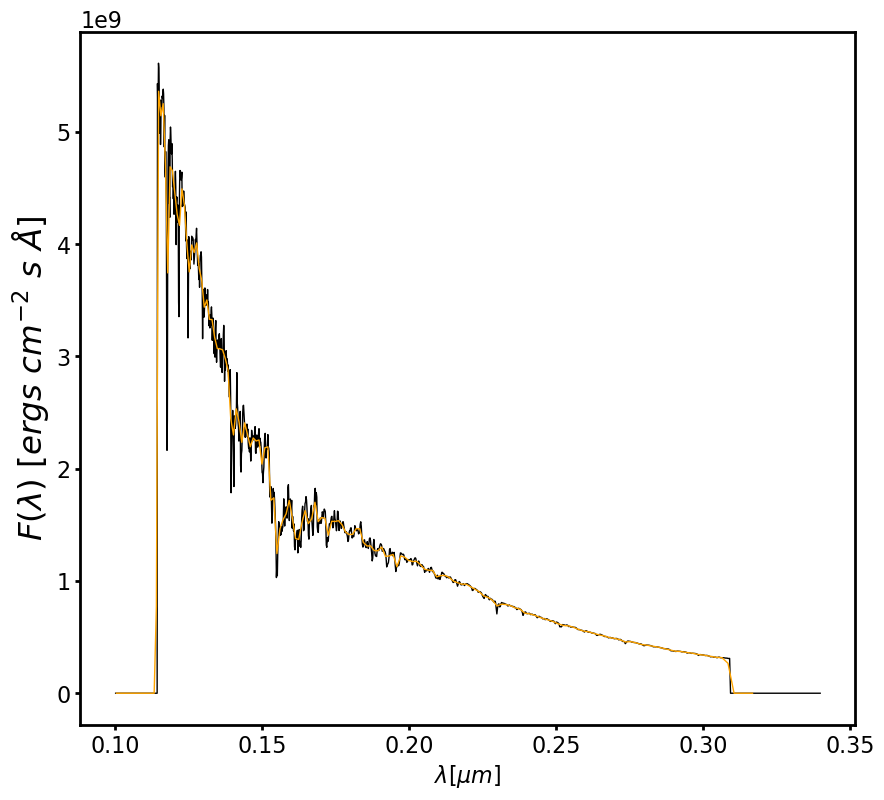

In [46]:
fig, ax = plt.subplots(figsize=(10, 9))
spec_n=410

for i in range(1):
    if plot_non_rb:
        ax.plot(
            modinfo_not_rb.waves["STIS"], 
            modinfo_not_rb.fluxes["STIS"][spec_n], c='k')
    ax.plot(
        modinfo_rb.waves["STIS"], 
        modinfo_rb.fluxes["STIS"][spec_n], c='orange'
        )
ax.set_xlabel("$\lambda [\mu m]$")
ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
plt.savefig(savefile_path + "/mod_spec_gres_" + str(gres) + ".pdf")

#### (optional) Test exclusion of zero-flux data & exclusion of data in a WL range (.17 -- .2 um)

============ Star is m31_e13_j004539.70+415054.8 ====================
file path /Users/pyanchulova/Documents/extstar_data/
fstarname m31_e13_j004539.70+415054.8.dat
len negative nvals [False False False ... False False False]
Remove F275W? True
len negative nvals [False False False ... False False False]
zero flux [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18 172]
len zero flux 20
Remove F275W? True
================ Plotting NaN fluxes ================
Length of fluxes with naninds:  20


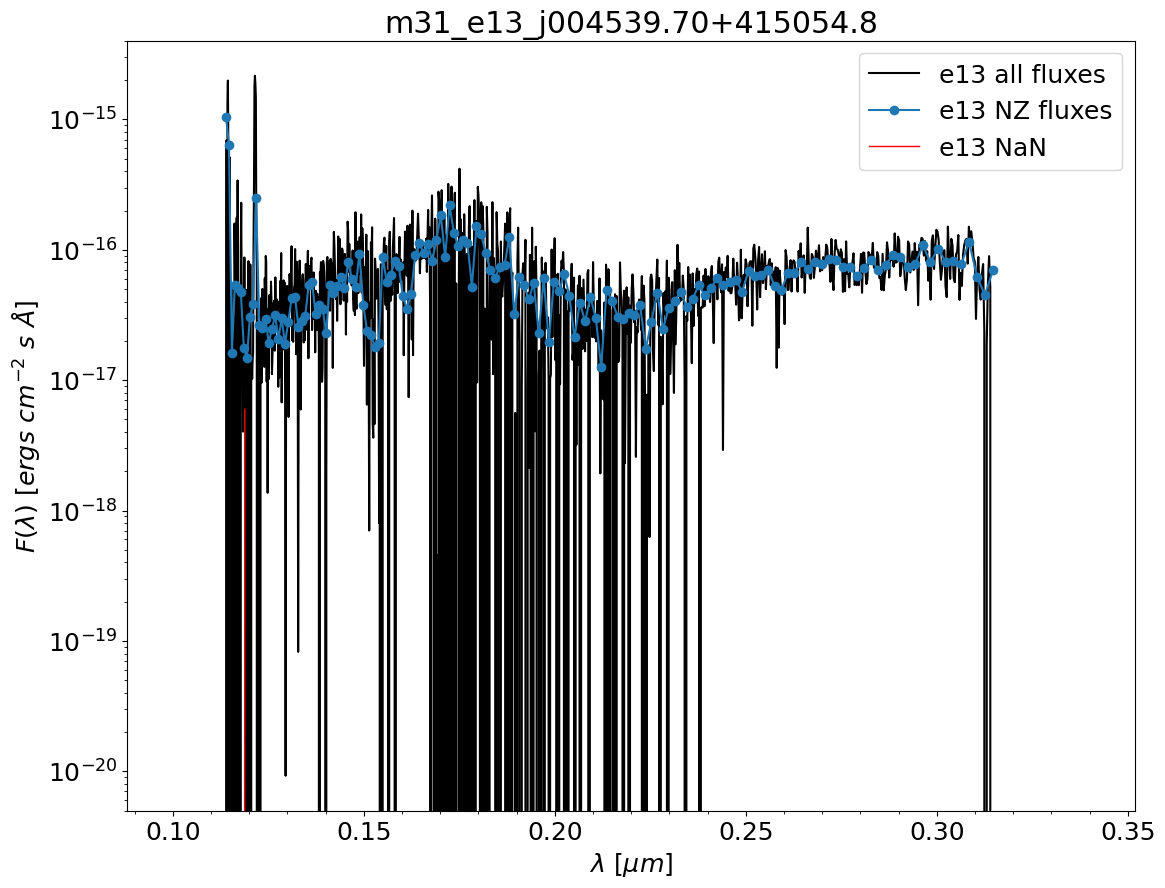

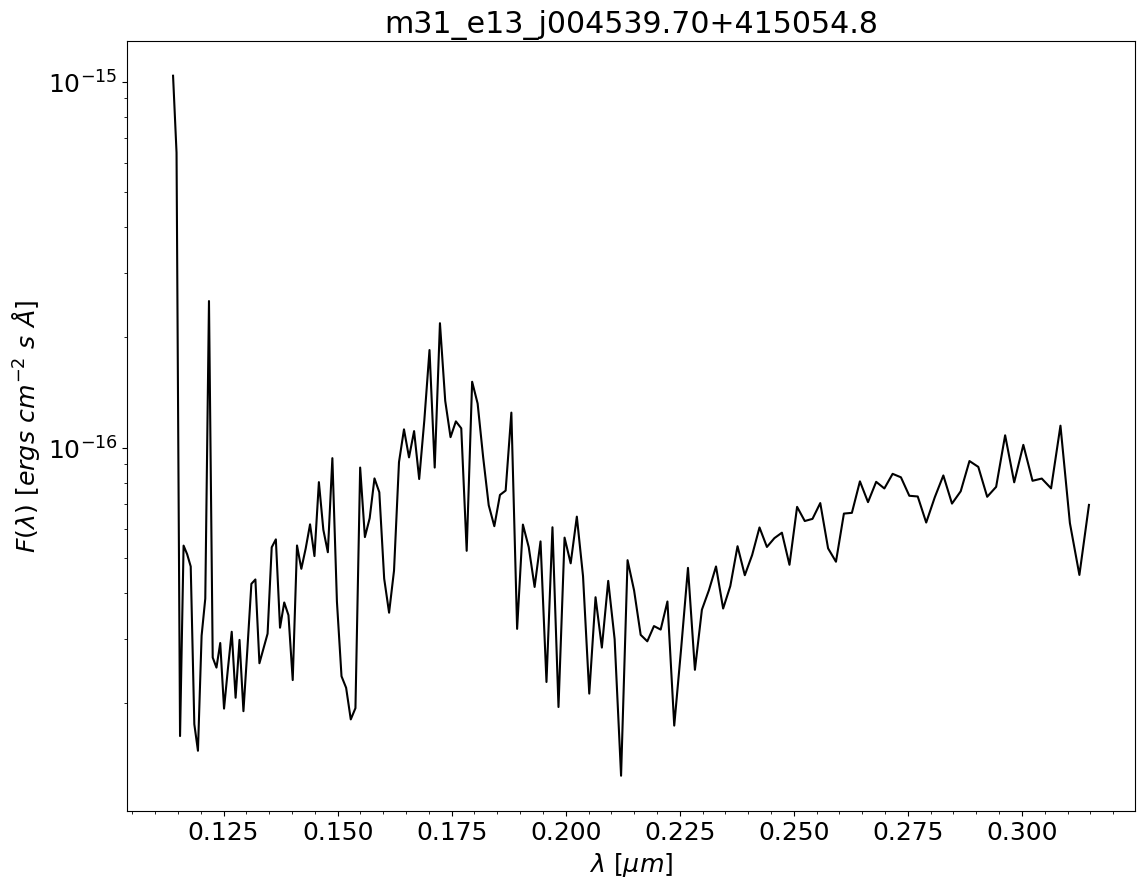

In [23]:
# m31_list=m31_list[-5:]
print (m31_list)

### (optional) Test exclusion of zero-flux data & exclusion of data in a WL range (.17 -- .2 um)

In [42]:
excl_wls = [.17, .2] # wavelength range to exclude, in microns
savefig = True

for i in range(len(m31_list)):
    starname = m31_list[i]
    fstarname = f"{starname}.dat"
    path = f"{file_path}/DAT_files/"
    starstr = starname.split(gal_str)[1].split("_")[0]
    print('============ Star is %s ====================' % starname)
    print('file path', file_path)
    print('fstarname', fstarname)

    # Get star data, WITHOUT excluding zero flux, for plotting
    # gindxs are flux indices of exclided WL range
    red_star_a, band_names_a, data_names_a, gindxs, excl_fluxes, naninds_n, nan_fluxes_n = get_red_star(fstarname, 
                                                                                                    file_path, 
                                                                                                    excl_zero=False, 
                                                                                                    excl_wls=False,
                                                                                                    rebin=False   )

    # Get star data, with non-zero flux; gindxs = flux inds of exclided WL range
    red_star_nz, band_names_nz, data_names_nz, gindxs, excl_fluxes, naninds, nan_fluxes = get_red_star(fstarname, 
                                                                                                       file_path, 
                                                                                                       excl_zero=True, 
                                                                                                       excl_wls=excl_wls)
    # Not sure why these are needed
    # norm_data_a = np.average(red_star_a.data["BAND"].fluxes)
    # norm_data_nz = np.average(red_star_nz.data["BAND"].fluxes)
    # norm_flux_a = red_star_a.data["STIS"].fluxes / norm_data_a
    # norm_flux_nz = red_star_nz.data["STIS"].fluxes / norm_data_nz
    
    # print("===== naninds: %s =======" % len(naninds))
    # print("===== gindxs: %s =======" % len(gindxs))
    
    # Plot spectra, both with and w/o zero fluxes
    fig, ax = plt.subplots(figsize=(13, 10))
    ax.plot(red_star_a.data["STIS"].waves, red_star_a.data["STIS"].fluxes, "k-", label=starstr + " all fluxes")
    ax.plot(red_star_nz.data["STIS"].waves, red_star_nz.data["STIS"].fluxes, "o-", label=starstr + " NZ fluxes")

    # Plot excluded data as a dashed line
    if excl_wls:
        print("=============== Plotting excluded WLs ==============")
        ax.plot(red_star_a.data["STIS"].waves[gindxs], excl_fluxes, ls="--", lw=1, c='gray', label=starstr + " excl fluxes")
    
    # Plot NaN fluxes (there are always some)
    print("================ Plotting NaN fluxes ================")
    print('Length of fluxes with naninds: ', len(red_star_a.data["STIS"].fluxes[naninds]))
    ax.plot(red_star_a.data["STIS"].waves[naninds], red_star_a.data["STIS"].fluxes[naninds], 
            ls="-", lw=1, c='r', label=starstr + " NaN")
    
    ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
    ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
    # ax.set_xlim(0.11,0.32)
    ylim = ax.get_ylim()
    # ax.set_ylim(-0.5e-15, 0.2e-15) # 1e-22
    ax.set_yscale("log")
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    plt.legend()
    ax.set_title(starname)
    if savefig:
        plt.savefig(savefile_path + "non_zero_flux_spectra_" + gal_str.split("_")[0] + "/" + 
                    starstr + "all_t1.png")
        plt.close()

        
    # ================== Plot only non-zero fluxes, and excluded fluxes as a dashed line =====================
    fig, ax = plt.subplots(figsize=(13, 10))
    ax.plot(red_star_nz.data["STIS"].waves, red_star_nz.data["STIS"].fluxes, "k-", label=starstr + " NZ fluxes")
    if excl_wls:
        ax.plot(red_star.data["STIS"].waves[gindxs], excl_fluxes, ls="--", lw=1, c='gray', label=starstr + " excl fluxes")
    ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
    ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
    # ax.set_xlim(0.11,0.32)
    ylim = ax.get_ylim()
    # ax.set_ylim(1e-18, ylim[1])
    ax.set_yscale("log")
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.set_title(starname)
    # plt.legend()
    if savefig:
        plt.savefig(savefile_path + "non_zero_flux_spectra_" + gal_str.split("_")[0] + "/" + 
                    starstr + "nz_t1.png")
        plt.close()

reddened_star.data.keys() dict_keys(['BAND', 'STIS'])
removing ends
Excluded end wavelengths, short: [0.10005006 0.10015022 0.10025048]
Excluded end wavelengths, long: [0.33982998 0.3394901  0.33915057]
band bames, pre cutting bands ['U', 'B', 'V', 'R', 'I']
Removing F275W
band bames ['B', 'V', 'R', 'I']
reddened_star.data.keys() dict_keys(['BAND', 'STIS'])
removing ends
Excluded end wavelengths, short: [0.10005006 0.10015022 0.10025048]
Excluded end wavelengths, long: [0.33982998 0.3394901  0.33915057]
band bames, pre cutting bands ['U', 'B', 'V', 'R', 'I']
Removing F275W
band bames ['B', 'V', 'R', 'I']
reddened_star.data.keys() dict_keys(['BAND', 'STIS'])
removing ends
Excluded end wavelengths, short: [0.10005006 0.10015022 0.10025048]
Excluded end wavelengths, long: [0.33982998 0.3394901  0.33915057]
band bames, pre cutting bands ['U', 'B', 'V', 'R', 'I']
Removing F275W
band bames ['B', 'V', 'R', 'I']
reddened_star.data.keys() dict_keys(['BAND', 'STIS'])
removing ends
Excluded end w

#### (Optional for now) Calculate spectra - photometry scaling factor

In [46]:
# various options

for i in range(len(m31_list)):
    starname = m31_list[i]
    fstarname = f"{starname}.dat"
    path = f"{file_path}/DAT_files/"
    starstr = starname.split(gal_str)[1].split("_")[0]
    
    # Calculate spectra correction scaling factor after comparing photometry 
    # obtained from spectra with the band photometry
    reddened_star = StarData(fstarname, path=path)
    print(reddened_star.data.keys())
    # corfac = scale_spex_spec.calc_save_corfac_spex(starname, path=f"{file_path}/DAT_files/")



### Spectra-phot correction factor

In [150]:
def spec_corr(galaxy='m33', starstr='e1'):
    """
    """
    # Adjust spectra amounts
    if galaxy == 'm33':
        if starstr == 'e1':
            spec_adj = 0.7 
        elif starstr == 'e2':
            spec_adj = 0.175 
        elif starstr == 'e3':
            spec_adj = 6.4 
        elif starstr == 'e4':
            spec_adj = 0.7 
        elif starstr == 'e5':
            spec_adj = 0.06 
        elif starstr == 'e6':
            spec_adj = 0.7
        elif starstr == 'e7':
            spec_adj = 0.85 
        elif starstr == 'e8':
            spec_adj = 0.22 
        else:
            spec_adj = 0.0
    else: # m31
        if starstr == 'e1':
            spec_adj = 0.7 #1 #2 
        elif starstr == 'e2':
            spec_adj = 0.7
        elif starstr == 'e3':
            spec_adj = 0.65 
        elif starstr == 'e4':
            spec_adj = 0.59 
        elif starstr == 'e5':
            spec_adj = 0.55 
        elif starstr == 'e6':
            spec_adj = 0.75 
        elif starstr == 'e7':
            spec_adj = 0.68 
        elif starstr == 'e8':
            spec_adj = 0.78 
        elif starstr == 'e9':
            spec_adj = 1.1
        elif starstr == 'e12':
            spec_adj = 0.8
        elif starstr == 'e13':
            spec_adj = 0.7
        elif starstr == 'e14':
            spec_adj = 0.7 # 0.8 #0.73
        elif starstr == 'e15':
            spec_adj = 0.7
        elif starstr == 'e17':
            spec_adj = 1.1 #0.9
        elif starstr == 'e18':
            spec_adj = 1.1 #0.9
        elif starstr == 'e22':
            spec_adj = 0.65 #0.9
        elif starstr == 'e24':
            spec_adj = 1.05
    
    return spec_adj

#### (optional) Plot rebinned spectra + find spec-phot corr factor (measure_extinction)

EXCLUDING fluxes


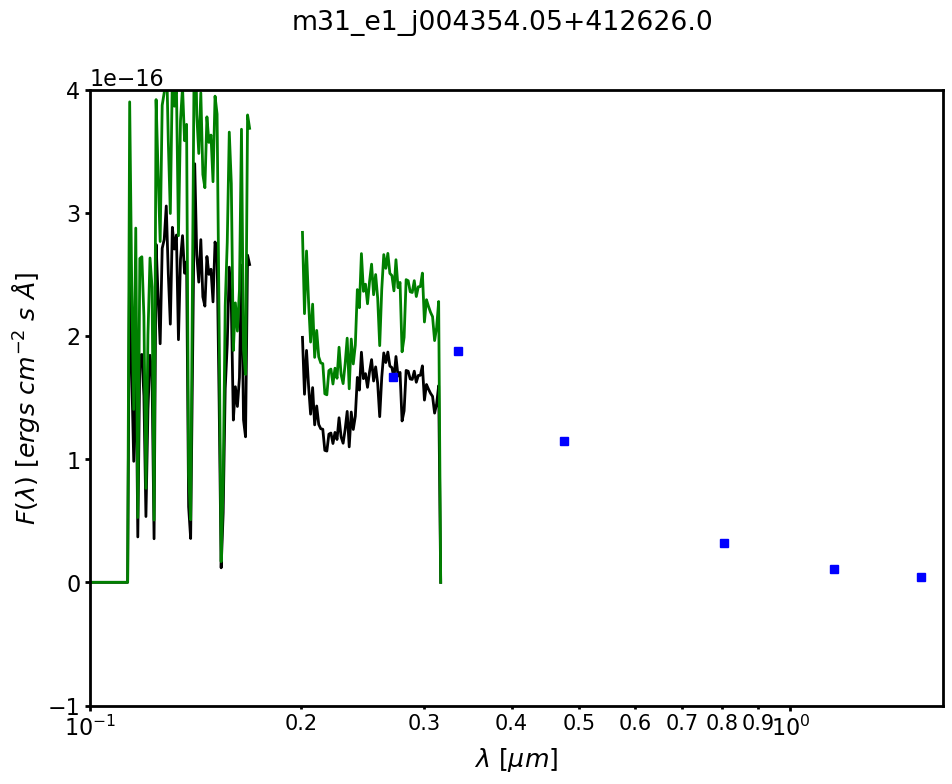

In [227]:
# Rebin params
# Tested resolutions: 125, 250, 500, 750; Data ~= 1000; > Data: 1250, 1500, 2000
rwaverange = [0.1, 0.32] * u.micron
gres = 150
plot_zoomed = False
plot_norm = False
plot_non_rebinned = False
plot_orig_res_data=False # Do we want to plot the unrebinned spectra
# m31_list=m31_list[0]

for i in range(len(m31_list)):
    starname = m31_list[i]
    fstarname = f"{starname}.dat"
    path = f"{file_path}/DAT_files/"
    starstr = starname.split(gal_str)[1].split("_")[0]

    # default settings
    #plot_spectrum(starname, path)

    # Get star data; default removes zero-flux data and flux in range 0.17 - 0.2 micron 
    red_star, band_names, data_names, gindxs, excl_fluxes = get_red_star(fstarname, file_path, rebin=False)
    norm_data = np.average(red_star.data["BAND"].fluxes)

    # ================== UV spectra WL range only ==============
    if plot_zoomed:
        fig, (ax,ax2) = plt.subplots(2, 1, figsize=(11, 12))
    else:
        plt.figure(figsize=(11, 8))
        ax = plt.gca()
        
    # plot the bands and all spectra for this star
    for cspec in data_names:
        ptype = "-"
        
        if cspec == "BAND":
            ptype = "s"
            label=""

        norm_flux = red_star.data[cspec].fluxes / norm_data
        if plot_norm:
            not_rb_data = norm_flux
        else:
            not_rb_data = red_star.data[cspec].fluxes
            
        if cspec == "BAND":
            clr="b" #"b"
        else:
            clr="k"

        # Plot default observations, not rebinned:
        if plot_orig_res_data:
            if cspec == "STIS":
                ax.plot(
                    red_star.data[cspec].waves,
                    not_rb_data,
                    clr + ptype,
                    label=label,
                    lw=1,
                    zorder=1
                    )            
        
        # REBIN an instance of the STIS spectra; just to show diff b/n rebined and not.
        if cspec == "STIS":

            spec_rb = red_star.data[cspec]
            spec_rb.rebin_constres(rwaverange, gres)
            rb_data = spec_rb.fluxes
            
            # ========================= Adjust spectra ===================
            spec_adj = spec_corr(galaxy, starstr)
            rb_data_adj = rb_data.value * spec_adj 
            
            # rb_data_excl_adj = rb_data_excl.value * spec_adj 
       
            # Plot rebinned and adjusted spectra
            ax.plot(
                spec_rb.waves,
                rb_data_adj,
                "k" + ptype, #"g"
                label="RB data:{}".format(gres) ,
                lw=2,
                zorder=2
            )
            
            ax.plot(
                spec_rb.waves,
                rb_data,
                "g" + ptype, #"g"
                label="RB data:{}".format(gres) ,
                lw=2,
                zorder=2
            )
            
            # Also plot excluded rebinned spectra, in gray
            # ax.plot(
            #     excl_wls,
            #     rb_data_excl_adj,
            #     c = "gray", ls='--',
            #     label="excl:{}".format(gres) ,
            #     lw=1,
            #     zorder=2
            # )
            
#             ax.plot(
#                 red_star.data[cspec].waves,
#                 red_star.data[cspec].fluxes,#norm_flux,
#                 "k" + ptype,
#                 label=label,)

        # Plot photometry on top
        if cspec == "BAND":
            ax.plot(
                red_star.data[cspec].waves,
                not_rb_data,
                clr + ptype,
                zorder=3)                    

        # Plot excluded fluxes
        # ax.plot(red_star.data["STIS"].waves[gindxs], excl_fluxes, ls="--", lw=1, c='gray', label=starstr + " excl fluxes")
        
        ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
        ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA]$", fontsize=1.3 * fontsize)

        # Set y-axis limits based on flux
        if 'm31' in gal_str:
            if starstr == 'e1':
                ax.set_ylim(-0.1e-15, 0.4e-15)
            if starstr == 'e2':
                ax.set_ylim(-0.04e-15, 1.1e-15)
            if starstr == 'e3':
                ax.set_ylim(-0.015e-15, 1.0e-15)
            if starstr == 'e4':
                ax.set_ylim(-0.15e-15, 0.4e-15)
            if starstr == 'e5':
                ax.set_ylim(-0.1e-15, 1.25e-15)
            if starstr == 'e6':
                ax.set_ylim(-0.1e-14, 2.3e-15)
            if starstr == 'e7':
                ax.set_ylim(-0.2e-15, 0.5e-15)
            if starstr == 'e8':
                ax.set_ylim(-0.2e-15, 0.8e-15)
            if starstr == 'e9':
                ax.set_ylim(-0.1e-15, 1e-15)
            if starstr == 'e12':
                ax.set_ylim(-0.2e-15, 0.05e-14)
            if starstr == 'e13':
                ax.set_ylim(-0.2e-15, 0.5e-15)
            if starstr == 'e14':
                ax.set_ylim(-0.11e-15, 0.4e-15)
            if starstr == 'e15':
                ax.set_ylim(-0.1e-15, 0.6e-15)
  
        elif 'm33' in gal_str:
            if starstr == 'e1':
                ax.set_ylim(-0.05e-15, 0.5e-15)
            if starstr == 'e2':
                ax.set_ylim(-0.05e-15, 0.7e-15)
            if starstr == 'e3':
                ax.set_ylim(-0.1e-15, 0.6e-15)
            if starstr == 'e4':
                # ax.set_ylim(-0.05e-15, 2.e-15)
                ax.set_ylim(-0.05e-15, 1.15e-15)
            if starstr == 'e6':
                ax.set_ylim(-0.1e-15, 0.4e-15)
            if starstr == 'e7':
                # ax.set_ylim(-0.1e-15, 0.85e-15)
                ax.set_ylim(-0.1e-15, 0.5e-15)
            if starstr == 'e8':
                ax.set_ylim(-0.1e-15, 0.3e-14)
    
        xl = (0.1, 1.65)
        ax.set_xlim(xl)
        ax.set_xscale('log')
        
        plt.tick_params(axis='both', which='minor', labelsize=15)
        ax.yaxis.set_minor_formatter(ticker.FormatStrFormatter("%.1f"))
        ax.xaxis.set_minor_formatter(ticker.FormatStrFormatter("%.1f"))
        ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=20))


    # ============ Zoomed plot ==================
    if plot_zoomed:
        red_star, band_names, data_names, gindxs, excl_fluxes, naninds, nan_fluxes = get_red_star(fstarname, file_path)

        for cspec in data_names:

            # zoomed plot
            norm_flux = red_star.data[cspec].fluxes / norm_data
            ax2.plot(
                red_star.data[cspec].waves,
                red_star.data[cspec].fluxes,#norm_flux,
                "k" + ptype,
            )
            if cspec == "STIS":
                ax2.plot(
                    spec_rb.waves,
                    spec_rb.fluxes,# / norm_data,
                    "r" + ptype,
                    lw=2
            )
            ax2.set_xlim(0.125,0.2)

    plt.suptitle(starname)
    
    if savefig:
        plt.savefig(savefile_path + "spectra/" + galaxy + "/" + starstr + "_" + \
                    gal_str + "spec_res_" + str(gres) + "_adj_nonadj.pdf", bbox_inches='tight')

#### (Optional) Plot stacked offset spectra

In [65]:
print(m31_list)

<>:286: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:286: SyntaxWarning: "is" with a literal. Did you mean "=="?


### (Optional) Plot stacked offset spectra

In [3]:
nstr = 21

<>:314: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:314: SyntaxWarning: "is" with a literal. Did you mean "=="?


e17
reddened_star.data.keys() dict_keys(['BAND', 'STIS'])
removing ends
Excluded end wavelengths, short: [0.10005006 0.10015022 0.10025048]
Excluded end wavelengths, long: [0.33982998 0.3394901  0.33915057]
band bames, pre cutting bands ['U', 'B', 'V', 'R', 'I']
Removing F275W
band bames ['B', 'V', 'R', 'I']
e18
reddened_star.data.keys() dict_keys(['BAND', 'STIS'])
removing ends
Excluded end wavelengths, short: [0.10005006 0.10015022 0.10025048]
Excluded end wavelengths, long: [0.33982998 0.3394901  0.33915057]
band bames, pre cutting bands ['U', 'B', 'V', 'R', 'I']
Removing F275W
band bames ['B', 'V', 'R', 'I']
e24
reddened_star.data.keys() dict_keys(['BAND', 'STIS'])
removing ends
Excluded end wavelengths, short: [0.10005006 0.10015022 0.10025048]
Excluded end wavelengths, long: [0.33982998 0.3394901  0.33915057]
band bames, pre cutting bands ['U', 'B', 'V', 'R', 'I']
Removing F275W
band bames ['B', 'V', 'R', 'I']
ordered list:
 ['m31_e24_j004412.17+413324.2' 'm31_e18_j003958.22+4023

/var/folders/th/45l2486x16lgmh0k83j7x2d80002lc/T/ipykernel_17694/3009739874.py:314: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if yot is 'multiply':


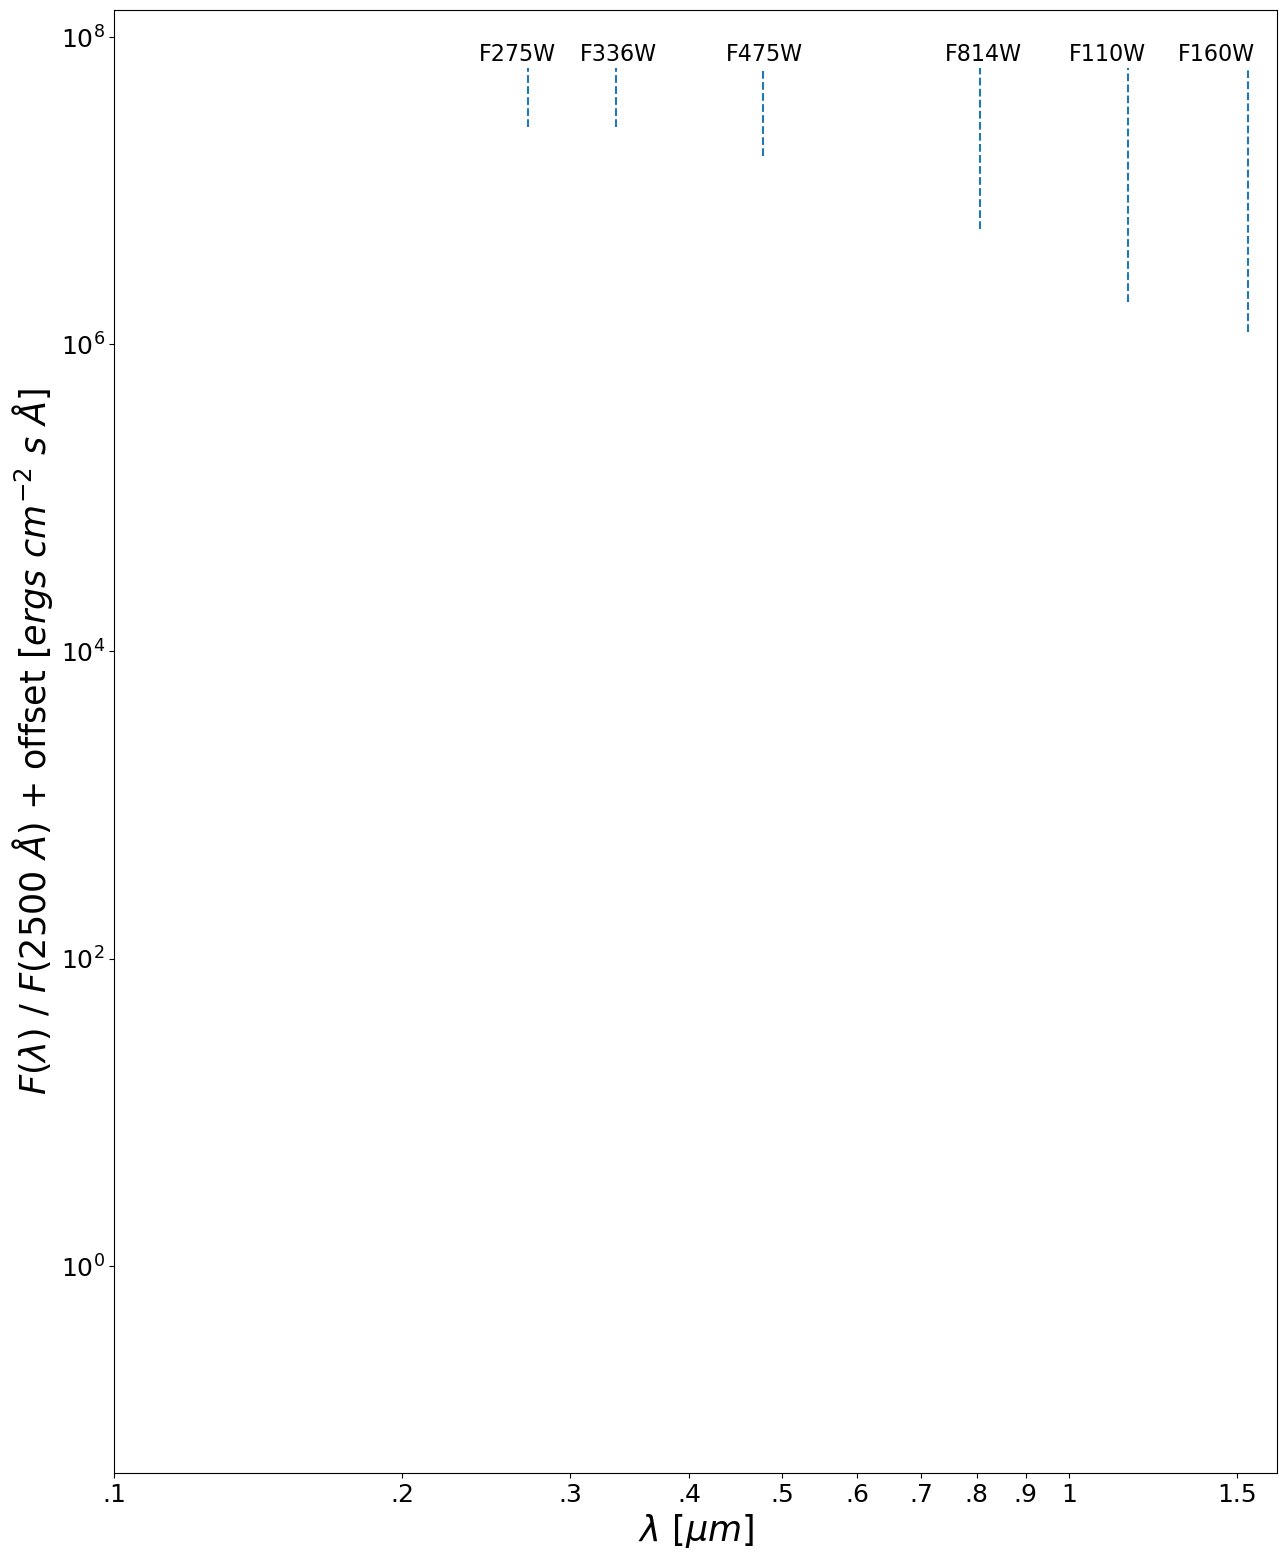

In [60]:
m31_list_full = True
measure_slopes = 'overwrite' #True
plot_4_m31_2015_stars = True
adjust_spectra = True
savefig=True
m31_list_old_uv_order = ['m31_e14_j004543.46+414513.6', 'm31_e5_j004431.66+413612.4',
                         'm31_e8_j004511.82+415025.3', 'm31_e24_j004412.17+413324.2',
                         'm31_e13_j004539.70+415054.8', 'm31_e4_j004427.47+415150.0',
                         'm31_e15_j004546.81+415431.7', 'm31_e12_j004539.00+415439.0', 
                         'm31_e6_j004438.71+415553.5', 'm31_e7_j004454.37+412823.9',
                         'm31_e3_j004420.52+411751.1', 'm31_e1_j004354.05+412626.0',
                         'm31_e22_j004034.61+404326.1', 'm31_e18_j003958.22+402329.0',
                         'm31_e2_j004413.84+414903.9', 'm31_e17_j003944.71+402056.2',
                         'm31_e9_j004511.85+413712.9']

if m31_list is None:
    if galaxy == 'm31':
        m31_list = [
                    "m31_e2_j004413.84+414903.9",
                    "m31_e3_j004420.52+411751.1", # ValueError: Initial state has a large condition number. Make sure that your walkers are linearly independent for the best performance
                    "m31_e4_j004427.47+415150.0",
                    "m31_e5_j004431.66+413612.4",
                    "m31_e7_j004454.37+412823.9",
                    "m31_e8_j004511.82+415025.3",
                    "m31_e9_j004511.85+413712.9", 
                    "m31_e12_j004539.00+415439.0",
                    "m31_e13_j004539.70+415054.8",
                    "m31_e15_j004546.81+415431.7", # UnboundLocalError: local variable 'fit_params_best' referenced before assignment
                    ]
                    # "m31_e6_j004438.71+415553.5", # error
                    # "m31_e1_j004354.05+412626.0", # Prob. w sorting by UV slope
                    # "m31_e10_j004512.73+413726.4", "m31_e11_j004535.40+414431.5", #No STIS data for e10 & e11
                    # "m31_e14_j004543.46+414513.6", # Prob. w sorting by UV slope
    else:
        m31_list = ["m33_e1_j013334.26+303327", "m33_e2_j013339.52+304540",
                    "m33_e4_j013344.59+304436", "m33_e7_j012241.93+304728", 
                    #"m33_e3_j013250.80+303507", "m33_e5_j013406.63+304147", 
                    #"m33_e6_j013410.59+304616", "m33_e8_j013416.10+303344.9"
                   ]
    
# if m31_list_full:
#     if galaxy == "m33":
#         m31_list = [
#                     "m33_e1_j013334.26+303327", 
#                     "m33_e2_j013339.52+304540",
#                     "m33_e3_j013250.80+303507", 
#                     "m33_e4_j013344.59+304436", 
#                     "m33_e5_j013406.63+304147", 
#                     # "m33_e6_j013410.59+304616", # bad spectra
#                     "m33_e7_j012241.93+304728", 
#                     # "m33_e8_j013416.10+303344.9" # half spectra
#                    ]
#     else:
#         m31_list = [
#                     "m31_e2_j004413.84+414903.9","m31_e3_j004420.52+411751.1",
#                     "m31_e4_j004427.47+415150.0","m31_e5_j004431.66+413612.4",
#                     "m31_e7_j004454.37+412823.9","m31_e8_j004511.82+415025.3","m31_e9_j004511.85+413712.9", 
#                     "m31_e12_j004539.00+415439.0","m31_e13_j004539.70+415054.8",
#                     "m31_e14_j004543.46+414513.6",
#                     "m31_e15_j004546.81+415431.7",
# ]

#         if plot_4_m31_2015_stars:
#             print("Plotting all stars, incl. 4 2015 M31 stars")
#             m31_list = [
#                         # "m31_e1_j004354.05+412626.0",
#                         # "m31_e2_j004413.84+414903.9","m31_e3_j004420.52+411751.1",
#                         # "m31_e4_j004427.47+415150.0","m31_e5_j004431.66+413612.4",
#                         # "m31_e6_j004438.71+415553.5",
#                         # "m31_e7_j004454.37+412823.9","m31_e8_j004511.82+415025.3","m31_e9_j004511.85+413712.9", 
#                         # "m31_e12_j004539.00+415439.0","m31_e13_j004539.70+415054.8",
#                         # "m31_e14_j004543.46+414513.6",
#                         # "m31_e15_j004546.81+415431.7",
#                         # "m31_e17_j003944.71+402056.2",
#                         # "m31_e18_j003958.22+402329.0",
#                         # "m31_e22_j004034.61+404326.1",
#                         # "m31_e24_j004412.17+413324.2",
#                 # ordere as original m31_list_uvsort
#                 "m31_e14_j004543.46+414513.6","m31_e5_j004431.66+413612.4",
#                 "m31_e8_j004511.82+415025.3", "m31_e24_j004412.17+413324.2",
#                 "m31_e13_j004539.70+415054.8", "m31_e4_j004427.47+415150.0",
#                 "m31_e15_j004546.81+415431.7", "m31_e12_j004539.00+415439.0",
#                  "m31_e6_j004438.71+415553.5", "m31_e7_j004454.37+412823.9",
#                 "m31_e3_j004420.52+411751.1", "m31_e1_j004354.05+412626.0",
#                 "m31_e22_j004034.61+404326.1", "m31_e18_j003958.22+402329.0",
#                 "m31_e2_j004413.84+414903.9", "m31_e17_j003944.71+402056.2",
#                 "m31_e9_j004511.85+413712.9"
#     ]
#                     # "m31_e10_j004512.73+413726.4", "m31_e11_j004535.40+414431.5", #No STIS data for e10 & e11]
# else:
#     if galaxy == "m33":
#         m31_list = ["m33_e1_j013334.26+303327", "m33_e2_j013339.52+304540",
#                     "m33_e4_j013344.59+304436", "m33_e7_j012241.93+304728", 
#                    ]
#     else:
#         m31_list = [
#         # "m31_e1_j004354.05+412626.0",
#                     "m31_e2_j004413.84+414903.9","m31_e3_j004420.52+411751.1",
#                     "m31_e4_j004427.47+415150.0","m31_e5_j004431.66+413612.4",
#                     # "m31_e6_j004438.71+415553.5",
#                     "m31_e7_j004454.37+412823.9","m31_e8_j004511.82+415025.3","m31_e9_j004511.85+413712.9", 
#                     "m31_e12_j004539.00+415439.0","m31_e13_j004539.70+415054.8",
#                     # "m31_e14_j004543.46+414513.6",
#                     "m31_e15_j004546.81+415431.7"]
        
# print(m31_list)
    
if measure_slopes:
    # Measure the UV slope so spectra can be ordered by it
    slopes = []
    for i, st in enumerate(m31_list):
        starname = st
        # print("st", st)
        # print("starname", starname)
        fstarname = f"{starname}.dat"
        starstr = starname.split(gal_str)[1].split("_")[0]
        print(starstr)

        reddened_star, band_names, data_names, gindxs, excl_fluxes, naninds, nan_fluxes = get_red_star(fstarname, 
                                                                                  file_path, 
                                                                                  excl_wls=False)
        
        v1 = np.logical_and(
                    reddened_star.data["STIS"].waves > 0.125 * u.micron,
                    reddened_star.data["STIS"].waves < 0.145 * u.micron,
                )
    #     vr1 = np.logical_and(v1, reddened_star.data["STIS"].npts > 0)
        v2 = np.logical_and(
                    reddened_star.data["STIS"].waves > 0.25 * u.micron,
                    reddened_star.data["STIS"].waves < 0.30 * u.micron,
                )

        slopes.append(
                    np.median(reddened_star.data["STIS"].fluxes[v1])
                    / np.median(reddened_star.data["STIS"].fluxes[v2])
                )
    # print("slopes", slopes)
    m31_list_arr = np.array(m31_list)
    # Order stars by UV slope
    m31_list_uvsort = m31_list_arr[np.argsort(slopes)]

print('ordered list:\n', m31_list_uvsort)
                
m31_list_arr = np.array(m31_list)
if measure_slopes == False:
    m31_list_uvsort = m31_list_arr
elif measure_slopes == 'overwrite':
    m31_list_uvsort = np.array(m31_list_old_uv_order)

print('m31 list order', m31_list_uvsort)
# Sorted in ascending UV slope order
# print("m31_list UV sorted", m31_list_uvsort)

# ============================================================================
fs=14
norm_data = np.average(reddened_star.data["BAND"].fluxes)
# norm_flux = red_star.data[cspec].fluxes / norm_data

# Define normalization WL
norm_wr = [0.24, 0.26] * u.micron

# colors = cycle(['teal', 'blue', 'magenta', 'gold', 'orange', 'deepskyblue'])
# colors = cycle(['blue', 'magenta', 'blue', 'magenta','blue', 'magenta'])
if m31_list_full:
    colors = cycle(['teal', 'blue', 'magenta', 'gold', 'orange', 'deepskyblue', 'crimson', 'limegreen', ])
else:
    colors = cycle(['teal', 'blue', 'magenta', 'orange'])

plot_one=False

yot = 'multiply'
half_num = len(m31_list) // 2 + 1

# fig, ax = plt.subplots(figsize=(13, 20))
ncols=1
fig, ax = plt.subplots(ncols=ncols, figsize=(15, 19))
spec_adj = 0.0

# Choose whether to use the UV-slope-sorted list
for i, st in enumerate(m31_list_uvsort): # m31_list_uvsort
    # print("Offset spectra plot", i)
    if plot_one:
        fstarname = f"{starname}.dat"
    else:
        starname = st
        # print(starname)
        fstarname = f"{starname}.dat"
    starstr = starname.split(gal_str)[1].split("_")[0]

    if 'e12' in st:
        excl_wls = [.17, .22]
    elif 'e1' in st:
        excl_wls = [.18, .2]
    elif 'e7' in st:
        excl_wls = [.17, .19]
    elif 'e12' in st:
        excl_wls = [.17, .2]
    elif 'e8' in st:
        excl_wls = [.168, .19]
    elif 'e13' in st:
        excl_wls = [.17, .2]
    elif 'e14' in st:
        excl_wls = [.16, .205]
    else:
        excl_wls = [.1601, .1602]

    # get all points
    red_star_a, \
    band_names_a, \
    data_names_a, \
    gindxs_a, \
    excl_fluxes_a = get_red_star(fstarname, file_path, excl_wls=[.1001, .1002])
    
    reddened_star, \
    band_names, \
    data_names, \
    gindxs, \
    excl_fluxes = get_red_star(fstarname, file_path, excl_wls=excl_wls)
    
    # Remove negative fluxes
    nvals = reddened_star.data["STIS"].fluxes < 0
    reddened_star.data["STIS"].npts[nvals] = 0
    
    # Rebin spectra
    reddened_star.data["STIS"].rebin_constres(rwaverange, gres)

        
    # Rebin excluded fluxes
    reddened_star_exc, band_names_exc, data_names_exc, gindxs_exc, excl_fluxes_exc = get_red_star(fstarname, file_path, excl_wls=excl_wls)
    # reddened_star_exc.data["STIS"].rebin_constres(rwaverange, gres)
    
    # If the entry is in the list's second half, offset by a number near star index
    if i // half_num > 0:
        offset = 2.5 ** (i - half_num)
        annotate_yoffset = 2.5 ** (0.05*(i - half_num))
    else:
        offset = 2.5 ** i
        annotate_yoffset = 2.5 ** (0.05*i)

    offset = 3 ** i #2.5 ** i
    annotate_yoffset = 0.0

    # Adjust spectra
    if adjust_spectra:
        spec_adj = spec_corr(galaxy, starstr)
        reddened_star.data["STIS"].fluxes = (reddened_star.data["STIS"].fluxes.value * spec_adj) * (u.erg / ((u.cm ** 2) * u.s * u.angstrom))
    # rb_data_adj = rb_data.value * spec_adj 
    
    reddened_star.data["STIS"].fluxes = (reddened_star.data["STIS"].fluxes.value * spec_adj) * (u.erg / ((u.cm ** 2) * u.s * u.angstrom))

    
#     spec_rb = reddened_star.data["STIS"]
#     spec_rb.rebin_constres(rwaverange, gres)
#     rb_data = spec_rb.fluxes
#     rb_data_adj = spec_rb.fluxes.value

    ax_i=ax
    if ncols==2:
        ax_i = ax[i // half_num]
    # reddened_star.plot(ax_i, 
    #                    pcolor=next(colors), 
    #                    yoffset=offset, 
    #                    yoffset_type=yot,
    #                    norm_wave_range=norm_wr,
    #                    annotate_key="STIS",
    #                    annotate_wave_range=[0.31, 0.315] * u.micron,
    #                    annotate_text=starstr,
    #                    annotate_rotation=-0.0,
    #                    annotate_yoffset=-0.2,
    #                    annotate_alignment='left',
    #                    fontsize=18)

    
    # Plot excluded spectra
    # ax.plot(red_star.data["STIS"].waves[gindxs_exc], excl_fluxes, ls="--", lw=1, c='gray', label=starstr + " excl fluxes")
    # ax_i.plot(reddened_star_exc.data["STIS"].waves[gindxs_exc], excl_fluxes_exc, ls="--", lw=1, c='gray')

    # Plot phot band names and lines
    if i==len(m31_list_uvsort)-1:
        # additional phometric filters for C15 4 stars:
        # F170W, F255W, F336W, F439W, F555W, F814W

        wfc3_bn = ["F275W","F336W","F475W","F814W","F110W","F160W"]
        wfc3_bw = np.array([0.2410, 0.307, 0.4372, 0.74, 1., 1.3])
        max_offset_bandflux = [100, 120, 70, 20, 8, 2]
        max_axis_range = [0.82, 0.82, 0.765, 0.62, 0.5, 0.4]

        wfc3_bw_exact = np.array([0.2710, 0.3355, 0.4772, 0.8053, 1.1534, 1.5369])

        for j in range(6):
            if galaxy == 'm33':
                # max_axis_range = [0.82, 0.82, 0.765, 0.62, 0.5, 0.4]
                max_axis_range = [0.84, 0.85, 0.78, 0.67, 0.57, 0.48]
                if m31_list_full:
                    ax_i.text(wfc3_bw[j], 300., '%s' % wfc3_bn[j], fontsize=16)
                else:
                    ax_i.text(wfc3_bw[j], 30, '%s' % wfc3_bn[j], fontsize=16)
                ax_i.axvline(wfc3_bw_exact[j], ymin=max_axis_range[j], ymax=0.91, linestyle='dashed')
            else:
                # max_axis_range = [0.85, 0.85, 0.81, 0.73, 0.66, 0.59]
                max_axis_range = [0.92, 0.92, 0.9, 0.85, 0.8, 0.78]

                if m31_list_full:
                    if plot_4_m31_2015_stars:
                        ax_i.text(wfc3_bw[j], 70000000., '%s' % wfc3_bn[j], fontsize=16)
                    else:
                        ax_i.text(wfc3_bw[j], 17000., '%s' % wfc3_bn[j], fontsize=16)
                # else:
                #     ax_i.text(wfc3_bw[j], 30, '%s' % wfc3_bn[j], fontsize=16)
                ax_i.axvline(wfc3_bw_exact[j], ymin=max_axis_range[j], ymax=0.96, linestyle='dashed')

# Set axes params and labels
ax_i=ax
if ncols==2:
    ax_i = ax[i]

xl = (0.1, 1.65)
ax_i.set_xlim(xl)

# ax_i.set_xlim(0.11, 0.32)
ylim = ax_i.get_ylim()

if yot is 'multiply':
    if m31_list_full:
        if galaxy=='m33':
            ax_i.set_ylim(2e-2, 650)
        else:
            ax_i.set_ylim(.04, 45000)
            if plot_4_m31_2015_stars:
                ax_i.set_ylim(.045, 1.5e8)
    else:
        ax_i.set_ylim(2e-2, 65)

ax_i.set_yscale("log")
ax_i.set_xscale("log")
ax_i.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.8 * fs)
ax_i.set_ylabel(
        r"$F(\lambda)$ / $F(2500~\AA)$ + offset [$ergs\ cm^{-2}\ s\ \AA$]",
        fontsize=1.8 * fs,
    )

ax_i.set_xticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1, 1.5], 
                labels=['.1','.2','.3','.4','.5','.6','.7','.8','.9','1', '1.5'])
ax_i.tick_params(axis='both', which='major', labelsize=18)
ax_i.tick_params(axis='both', which='minor', labelsize=18)
# ax_i.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax_i.xaxis.set_minor_locator(ticker.LogLocator(numticks=999, subs="auto"))

# ax_i.plot(reddened_star.data["STIS"].waves[gindxs_a], excl_fluxes_a, ls="--", lw=2, c='gray', label=starstr + " excl fluxes")
nstr+=1
if savefig:
    plt.savefig(savefile_path + "spectra_offset/" + galaxy + "/" + \
                gal_str + str(gres) + "_post_upd_spec_" + str(nstr) + "_ralph_new.png", bbox_inches='tight')


### Spectra-phot correction factor

In [7]:
def spec_corr(galaxy='m33', starstr='e1'):
    """
    """
    test=1234
    # Adjust spectra amounts
    if galaxy == 'm33':
        if starstr == 'e1':
            spec_adj = 1 #0.7 too much
        elif starstr == 'e2':
            spec_adj = 0.26 # 0.175 too much
        elif starstr == 'e3':
            spec_adj = 6.4 
        elif starstr == 'e4':
            spec_adj = 1 # 0.7 too much
        elif starstr == 'e5':
            spec_adj = 0.06 
        elif starstr == 'e6':
            spec_adj = 0.7
        elif starstr == 'e7':
            spec_adj = 1 #0.95 # 0.85 too much
        elif starstr == 'e8':
            spec_adj = 0.22 
        else:
            spec_adj = 0.0
    else: # m31
        if starstr == '':
            test = 2
        if starstr == 'e1':
            spec_adj = 1. #0.7 # Not needed
        elif starstr == 'e2':
            spec_adj = 1. #0.7
        elif starstr == 'e3':
            spec_adj = 1 #0.9 #0.65 
        elif starstr == 'e4':
            spec_adj = 1 # 0.59 
        elif starstr == 'e5':
            spec_adj = 0.95 #1.2 #0.95 # .55 too much; .7, w F275W remo, too small; .8 or .85 maybe too much
        elif starstr == 'e6':
            spec_adj = 0.95 # 0.75 too much after removal of F275
        elif starstr == 'e7':
            spec_adj = 0.95 #1 #0.85 #0.68 
        elif starstr == 'e8':
            spec_adj = 0.9 # 0.78
        elif starstr == 'e9':
            spec_adj = 0.85 # 0.5 too much; .8 may be too little; .87 too much
        elif starstr == 'e12':
            spec_adj = 0.9 #0.85 #0.8
        elif starstr == 'e13':
            spec_adj = 0.95 #0.7
        elif starstr == 'e14':
            spec_adj = 0.98 # 0.7 # 0.8 #0.73
        elif starstr == 'e15':
            spec_adj = 0.9 #0.7
        elif starstr == 'e17':
            spec_adj = 0.9
        elif starstr == 'e18':
            spec_adj = 0.9
        elif starstr == 'e22':
            spec_adj = 0.95 # 0.65 too much after removal of F275 #0.9
        elif starstr == 'e24':
            spec_adj = 0.9
    
    print("Spectra has been ADJUSTED by:", spec_adj)
    return spec_adj

### Create the weight arrays based on the observed uncertainties

In [47]:
def set_weights(data_names, reddened_star, add_excl=False, band_weight=10000.0):
    """
    """
    # cropping info for weights
    #  bad regions are those where we know the models do not work or the data is bad
    # pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4","x0","gamma","HI_gal","HI_mw"]

    ex_regions = [
        [8.23 - 0.1, 8.23 + 0.1],  # geocoronal line
        [8.7, 10.0],  # bad data from STIS; zeros (for all stars)
        [3.55, 3.6],
        [3.80, 3.90],
        [4.15, 4.3],
        [6.4, 6.6],
        [7.1, 7.3],
        [7.45, 7.55],
        [7.65, 7.75],
        [7.9, 7.95],
        [8.05, 8.1],
        [5.13, 5.88],
        [2.94, 3.17]
    ] / u.micron

    if add_excl:
        add_excl = [1./x for x in add_excl]
        ex_regions = [
            [8.23 - 0.1, 8.23 + 0.1],  # geocoronal line
            [8.7, 10.0],  # bad data from STIS; zeros (for all stars)
            [3.55, 3.6],
            [3.80, 3.90],
            [4.15, 4.3],
            [6.4, 6.6],
            [7.1, 7.3],
            [7.45, 7.55],
            [7.65, 7.75],
            [7.9, 7.95],
            [8.05, 8.1],
            [5.13, 5.88],
            [2.94, 3.17],
            add_excl,
        ] / u.micron

    weights = {}
    for cspec in data_names:
        weights[cspec] = np.full(len(reddened_star.data[cspec].fluxes), 0.0)
        gvals = reddened_star.data[cspec].npts > 0
        weights[cspec][gvals] = 1.0 / reddened_star.data[cspec].uncs[gvals].value

        x = 1.0 / reddened_star.data[cspec].waves
        for cexreg in ex_regions:
            # print("Excluding wavelengths")
            weights[cspec][np.logical_and(x >= cexreg[0], x <= cexreg[1])] = 0.0

    # make the photometric bands have higher weight
    weights["BAND"] *= band_weight #10000.0
    
    return weights, ex_regions

### Setup the fit parameters

In [20]:
def setparams(modinfo, logt=4.25, logg=3.09, logz=0.0, av=0.75, rv=3.1, c2=2.5, c3=0.65, c4=0.26, \
              x0=4.66, g=0.86 , hig=21.0, himw=19.0):
    """
    Set the initial starting position, customize for each star.
    # SMC metallicity -> 0.2 (1/5 solar)
    # Orig params = [4.25, 3.09, 0.2, 0.75, 3.7, 2.5, 0.65, 0.26, 4.66, 0.86, 22.0, 19.0]
    """
    # parameter names
    pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4","x0","gamma","HI_gal","HI_mw"]

    params = [logt, logg, logz, av, rv, c2, c3, c4, x0, g, hig, himw]

    # min/max allowed values for each parameter
    # some are based on the min/max of the stellar atmosphere grid
    plimits = [
            [modinfo.temps_min, modinfo.temps_max],  # log(Teff)
            [modinfo.gravs_min, modinfo.gravs_max],  # log(g)
            [modinfo.mets_min, modinfo.mets_max],    # log(Z)
            [0.0, 4.0],   # Av
            [2.0, 6.0],   # Rv
            [-0.5, 5.0],  # C2
            [0.0, 6],   # C3
            [-0.2, 2.0],   # C4
            [4.53, 4.65],   # x0
            [0., 2.5],   # gamma
            [17.0, 24.0], # log(HI) internal to galaxy
            [17.0, 22.0], # log(HI) MW foreground
        ]

    print('log(Teff) range:', modinfo.temps_min, modinfo.temps_max)
    print('log(g) range:', modinfo.gravs_min, modinfo.gravs_max)
    print('Z range:', modinfo.mets_min, modinfo.mets_max)
    # add Gaussian priors based on prior knowledge
    #  sptype -> log(Teff), log(g)
    #  galaxy metallicity -> log(Z)
    print("Priors are logT={}, logg={}, logZ={}".format(logt, logg, logz))
    ppriors = {}
    ppriors["logT"] = (logt, 0.15) #logt prior can vary by thousands (SpT )
    ppriors["logg"] = (logg, 0.1)
    ppriors["logZ"] = (logz, 0.1)

    print('in set')
    print('params: T:', 10**logt, 
          'logg:', float(logg), 
          'logz:', 10**logz, 
          )

    return pnames, params, plimits, ppriors    

### Package the fit info needed.  FitInfo class defines the likelihood functions as well.

In [9]:
def package_fitinfo(pnames, plimits, weights, ppriors, velocity):
    """
    """
    # print('ppriors',ppriors)
    fitinfo = FitInfo(
        pnames,
        plimits,
        weights,
        parameter_priors=ppriors,
        stellar_velocity=velocity,
    )
    return fitinfo

### Turn log(likelihood) into chi^2
Needed since op.minimize searchs for the min chisqr (not max likelihood like MCMC algorithms)

In [10]:
# simple function to turn the log(likelihood) into the chisqr
def log_l_to_chi2(fitinfo, params, reddened_star, modinfo, method="Nelder-Mead"): #, maxiter
    """
    nll = function to be minimized
    params = initial guess
    method = type of solver
    args = extra arguments passed to the fn to be minimized
    """
# result = op.minimize(
#    nll, params, method="Nelder-Mead", args=(reddened_star, modinfo, fitinfo)
# def lnprob(params, obsdata, modeldata, fitinfo):

    # run the fit
#     nll_w_fitinfo = -fitinfo.lnprob(reddened_star, modinfo, fitinfo)
    result = op.minimize(
        nll, params, method="Nelder-Mead", 
        args=(reddened_star, modinfo, fitinfo), options={"maxiter": 1000})
    print("\n\n PPRIORS ", fitinfo.parameter_priors, "\n\n")
    # check the fit output
    print("in log_l_to_chi2.", result["message"])
    print("Success?", result["success"])
    return result

In [11]:
def nll(*args):
    print(fitinfo.lnprob(*args))
    print("\n\n\n nll \n\n")
    return -fitinfo.lnprob(*args)

### Save dust param results from optimizer calc

In [12]:
def save_results(result, pnames, print=False):
    """
    """
    params = result["x"]
    fit_params = params
    params_best = params
    pnames_extra = pnames

    if print:
        print("Best fit")
        for k, val in enumerate(params_best):
            print("{} # {}".format(val, pnames_extra[k]))
        
    return params, fit_params, params_best, pnames_extra

### Calculate, plot, and save the extinction curve (longer version)

In [103]:
def calc_plot_ext_curve(modinfo,
                        fit_params, 
                        velocity, 
                        relband, 
                        reddened_star,
                        gindxs,
                        excl_fluxes,
                        reddened_star_a,
                        starname, 
                        params, 
                        starstr,
                        save_ext_curve,
                        plot_ext_curve,
                        excl_wls,
                        optstr=''):
    
    """
    optstr   Plot and/or save ext_curve with optstr in fname to distinguish from nonopt version
    """
    
    # intrinsic sed: log(T), log(g), Z, Av
    print('Stellar params in cal_plot_ext_curve', fit_params[0:3])
    modsed = modinfo.stellar_sed(fit_params[0:3], velocity=velocity)
    print('FIT params [0:3]', fit_params[0:3])

    # dust_extinguished sed: Av, etc.
    ext_modsed = modinfo.dust_extinguished_sed(fit_params[3:10], modsed)

    # hi_abs sed
    hi_ext_modsed = modinfo.hi_abs_sed(
        fit_params[10:12], [velocity, 0.0], ext_modsed)

    # create a StarData object for the best fit SED
    modsed_stardata = modinfo.SED_to_StarData(modsed)

    print('N waves data', len(reddened_star.data["STIS"].waves))
    print('len modsed waves', len(modsed_stardata.data["STIS"].waves))

    # create an extincion curve and save it
    extdata = ExtData()
    
    # Calculate the E(lambda-X) for the photometric band data
    extdata.calc_elx(reddened_star, modsed_stardata, rel_band=relband)
    col_info = {"av": fit_params[3], "rv": fit_params[4]}

    # transform E(l-F475) to E(l - V)/E(B-V):
    # Add F475W and subtract Av
    # determine the index for the F475W band
    dwaves = np.absolute(extdata.waves["BAND"] - 0.4747 * u.micron)
    sindxs = np.argsort(dwaves) # or dwaves.argmin() 
    f475indx = sindxs[0]
    ef475v = extdata.exts["BAND"][sindxs] #E(F475W - V)
    af475w_av = 1.13 # From PYMJ 2017 Af475/Af550
    af475w = ef475v / (af475w_av - 1)
    # finally, add Af475 & subtract Av
    # extdata.exts[src][indxs]
    print("A_F475W", af475w)
    (indxs,) = np.where(
                    (reddened_star.data["STIS"].npts > 0)
                    & (modsed_stardata.data["STIS"].npts > 0)
                    & (reddened_star.data["STIS"].fluxes.value > 0)
                    & (modsed_stardata.data["STIS"].fluxes.value > 0)
                )
    # extdata.exts = extdata.exts["STIS"][indxs] + af475w[0]
    
    # Now subtract Av

    # Then divide by E(B-V)
    # ebv = _get_column_plus_unc(extdata.columns["EBV"])
    # e_bv = extdata.calc_EBV(reddened_star, modsed_stardata, rel_band=relband)
    # extdata = extdata / e_bv
    
    if save_ext_curve:
        extdata.save("extcurves/" + gal_str + '/' + gal_str + "_" + starstr + "_ext_rb_" + optstr + "_" + \
                     str(gres) + "_res_postCorr_check_SpT.fits") #, column_info=col_info)
        print("extinction curve type", extdata.type)
    
    # =============== PLOT the extinction curve =========================
    if plot_ext_curve:
        fig, ax = plt.subplots(figsize=(13, 10))

        # convert from E(l-V) to A(l)/A(V)
        extdata.columns["AV"] = (params[3], 0.0)
        # extdata.trans_elv_alav() # but we have El/Ef475, bot El/Ev
        # extdata.trans_elv_elvebv()

        # Data
        print('in calc plot ext curve, excl_wls', excl_wls)
        if excl_wls:
            extdata.plot(ax, color='k', exclude=excl_wls) #, lw=1.3) #'deepskyblue')#, alax=True)
        else:
            extdata.plot(ax, color='k') #, lw=1.3) #'deepskyblue')#, alax=True)
        ax.set_xscale("log")
        ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
        # ax.set_ylim(0.0, 10.0)
        # ax.set_ylabel(r"$E(\lambda$ - %s)" % relband_str, fontsize=1.3 * fontsize)
        # ax.set_ylabel(r"$E(\lambda$ - %s)/E(B-V)" % relband_str, fontsize=1.3 * fontsize)
        ax.set_ylabel(r"$E(\lambda$ - V)/E(B-V)", fontsize=1.3 * fontsize)
        # ax.set_ylabel(r"$A_{\lambda}$/$A_V$", fontsize=1.3 * fontsize)
        ax.tick_params("both", length=10, width=2, which="major")
        ax.tick_params("both", length=5, width=1, which="minor")

        # plot known exitnction curves
        mod_x = np.arange(0.3, 8.7, 0.1) / u.micron
        smcbar = G03_SMCBar()
        Af475wAv = smcbar(0.475 * u.micron)
        smcbar_el475w = (smcbar(mod_x) - Af475wAv) * params[3]
        ax.plot(1.0 / mod_x, smcbar_el475w, "b", label="SMC Bar, G03", lw=1.) # "k:"

        f19_rv31 = F19(Rv=3.1)
        Af475wAv = f19_rv31(0.475 * u.micron)
        f19_el475w = (f19_rv31(mod_x) - Af475wAv) * params[3]
        ax.plot(1.0 / mod_x, f19_el475w, "r", lw=1., label="MW Rv=3.1, F19") #"k-"
        
        lmcave = G03_LMCAvg()
        Af475wAv = lmcave(0.475 * u.micron)
        lmcave_el475w = (lmcave(mod_x) - Af475wAv) * params[3]
        ax.plot(1.0 / mod_x, lmcave_el475w, "g", label="LMC Ave, G03", lw=1.)

        ax.set_title("%s" % starname)
        ax.legend()
        plt.savefig(savefile_path + "ext_curves/" + gal_str + '/' + gal_str + starstr + \
                    "_extcurve_" + optstr + "_" + str(gres) + "_AlAv.png")
    
    return modsed, ext_modsed, hi_ext_modsed, modsed_stardata, extdata, col_info

### Save ext curve (quick, no optimizer needed)

In [14]:
def save_ext_curve_quick(modinfo,
                         fit_params, 
                         velocity,
                         relband, 
                         reddened_star, 
                         starname, 
                         params, 
                         starstr):
    """
    """
    
    # intrinsic sed
    modsed = modinfo.stellar_sed(fit_params[0:3], velocity=velocity)

    # dust_extinguished sed
    ext_modsed = modinfo.dust_extinguished_sed(fit_params[3:10], modsed)

    # hi_abs sed
    hi_ext_modsed = modinfo.hi_abs_sed(
        fit_params[10:12], [velocity, 0.0], ext_modsed
    )

    # create a StarData object for the best fit SED
    modsed_stardata = modinfo.SED_to_StarData(modsed)

    # create an extincion curve and save it
    extdata = ExtData()
    extdata.calc_elx(reddened_star, modsed_stardata, rel_band=relband)
    col_info = {"av": fit_params[3], "rv": fit_params[4]}
    extdata.save("extcurves/" + gal_str + '/' + gal_str + "_" + starstr + "_ext_rb_" + str(gres) + "norm_res.fits", column_info=col_info)
    # old save:
    # extdata.save(gal_str + starname + "_ext.fits", column_info=col_info)

### Read initial positions from file

In [15]:
def read_init_pos(starstr):
    """
    Read in the params specifying the best-fit intial position
    """
    
    # print("\nstarname", starname, "\n")

    initial_pos_file = "initial_pos/" + galaxy + "/" + starstr + "_start.dat" 
    ipdata = np.fromfile(initial_pos_file, dtype="float", sep=" ")
    # print('init pos file', initial_pos_file)
    # print('test: ipdata[0]', ipdata[0])
    
    if len(ipdata) < 12 or len(ipdata) > 12:
        print("WARNING: Initial position data has fewer/more elements than expected.")

    logtgrid = [ipdata[0]]
    logggrid = [ipdata[1]]
    logzgrid = [ipdata[2]]
    avgrid = [ipdata[3]]
    rvgrid = [ipdata[4]]
    c2grid = [ipdata[5]]
    c3grid = [ipdata[6]]
    c4grid = [ipdata[7]]
    x0grid = [ipdata[8]]
    gammagrid = [ipdata[9]]
    hi_galgrid = [ipdata[10]]
    hi_mwgrid = [ipdata[11]]

    return logtgrid, logggrid, logzgrid, \
            avgrid, rvgrid, c2grid, c3grid, \
            c4grid, x0grid, gammagrid, \
            hi_galgrid, hi_mwgrid


### Set up parameter grid ranges

In [16]:
def setup_param_ranges(starname, starstr, small_vary=False):
    """
    """

    singlevalued = True

    # pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4","x0","gamma","HI_gal","HI_mw"]

    # Get initial positions
    logtgrid, logggrid, logzgrid, \
        avgrid, rvgrid, c2grid, c3grid, \
        c4grid, x0grid, gammagrid, \
        hi_galgrid, hi_mwgrid = read_init_pos(starstr)
    
    initial_grid = [logtgrid, logggrid, logzgrid, avgrid, rvgrid, c2grid, c3grid, \
                    c4grid, x0grid, gammagrid, hi_galgrid, hi_mwgrid]
    
    if singlevalued is False:
        # Introduce a small variation around the orig initial position
        if small_vary:
        # log(T) [4.11 4.31]
        # log(g) [2.55 2.85]
        # log(Z) [-0.1  0.1]
        # Av [0.9 1.1]
        # Rv [3.1]
        # c2 [1.2 1.4]
        # c3 [2.  2.2 2.4]
        # c4 [-0.11  0.09]
        # x0 [4.55 4.6 ]
        # gamma [0.65 0.85]
        # HI_gal [20. 21.]
        # HI_MW [18. 19.]
            logtgrid = np.arange(logtgrid[0]-0.15, logtgrid[0]+0.15, 0.2)
            logggrid = np.arange(logggrid[0]-0.2, logggrid[0]+0.2, 0.3)
            logzgrid = np.arange(-0.1, 0.2, 0.2)
            avgrid = np.arange(avgrid[0]-0.2, avgrid[0]+0.2, 0.2)
            rvgrid = [rvgrid[0]]
            c2grid = np.arange(c2grid[0]-0.2, c2grid[0]+0.2, 0.2) 
            c3grid = np.arange(c3grid[0]-0.15, c3grid[0]+0.15, 0.2)  
            if starstr == "e7":
                print("c4, e7")
                c4grid = np.arange(c4grid[0]-0.05, c4grid[0]+0.4, 0.3)
            elif starstr == 'e9':
                print("c4, e9, c4grid[0]", c4grid[0])
                c4grid = np.arange(c4grid[0]+0.03, c4grid[0]+0.6, 0.3)
            else:
                c4grid = np.arange(c4grid[0]-0.2, c4grid[0]+0.2, 0.2)
            x0grid = np.arange(x0grid[0]-0.05, x0grid[0]+0.05, 0.05)
            gammagrid = np.arange(gammagrid[0]-0.2, gammagrid[0]+0.1, 0.2)
            if starstr == "e8":
                hi_galgrid = np.arange(hi_galgrid[0], hi_galgrid[0]+1, 0.5)
                hi_mwgrid = np.arange(hi_mwgrid[0], hi_mwgrid[0]+1, 0.5)
            else:
                hi_galgrid = np.arange(hi_galgrid[0]-1, hi_galgrid[0]+1, 1)
                hi_mwgrid = np.arange(hi_mwgrid[0]-1, hi_mwgrid[0]+1, 1)
        else:
            logtgrid = np.arange(4.4, 4.43, 0.02);    logggrid = np.arange(2.75, 3., 0.5)
            logzgrid = np.arange(-0.3, 0.4, 0.1);    avgrid = np.arange(1.2, 1.3, 0.05)
            rvgrid = np.arange(3.1, 3.15, 0.1);    c2grid = np.arange(1.3, 1.4, 0.1) 
            c3grid = np.arange(2.2, 2.3, 0.1);    c4grid = np.arange(0.05, 0.075, 0.01)
            x0grid = np.arange(4.65, 4.71, 0.05);    gammagrid = np.arange(0.9, 0.91, 0.05)
    
    n_combos = len(logtgrid) * len(logggrid) * len(avgrid) * len(logzgrid) * \
                len(c2grid) * len(c3grid) * len(c4grid) * len(x0grid) * \
                len(gammagrid) * len(rvgrid) * len(hi_galgrid) * len(hi_mwgrid)
    # print("\nRun generates %s combination(s)" % n_combos)

    if n_combos > 2500:
        print("WARNING: Number of combinations is greater than 2500.")
    else:
        return initial_grid, logtgrid, logggrid, logzgrid, avgrid, rvgrid, c2grid, c3grid, c4grid, x0grid, gammagrid, hi_galgrid, hi_mwgrid

### Plot spectra: Intrinsic, Observations, Dust-extinguished

In [128]:
def plot_spectra_with_mod(modinfo, hi_ext_modsed, reddened_star, gindxs, excl_fluxes, reddened_star_a, modsed, ext_modsed,
                          modsed_stardata, starstr, params, initial_grid, runtype, ex_regions):
    """
    runtype:   (str) optimized or unoptimized fit
    """
    
    zoom_spec=False

    ex_regions = [
                [8.23 - 0.1, 8.23 + 0.1],  # geocoronal line
                [8.7, 10.0],  # bad data from STIS
                [3.55, 3.6],
                [3.80, 3.90],
                [4.15, 4.3],
                [6.4, 6.6],
                [7.1, 7.3],
                [7.45, 7.55],
                [7.65, 7.75],
                [7.9, 7.95],
                [8.05, 8.1],
            ] / u.micron

    norm_model = np.average(hi_ext_modsed["BAND"])
    norm_data = np.average(reddened_star.data["BAND"].fluxes)
    # e2: norm_data = 8.580566172965128e-17 erg / (Angstrom cm2 s)

    # plotting setup for easier to read plots
    fontsize = 16
    font = {"size": fontsize}
    mpl.rc("font", **font)
    mpl.rc("lines", linewidth=1)
    mpl.rc("axes", linewidth=2)
    mpl.rc("xtick.major", width=2)
    mpl.rc("xtick.minor", width=2)
    mpl.rc("ytick.major", width=2)
    mpl.rc("ytick.minor", width=2)

    # setup the plot
    fig, ax = plt.subplots(figsize=(17, 13))

    # plot the bands and all spectra for this star
    for cspec in modinfo.fluxes.keys():
        if cspec == "BAND":
            ptype = "o"
        else:
            ptype = "-"

        # Observations
        ax.plot(
            reddened_star.data[cspec].waves,
            reddened_star.data[cspec].fluxes / norm_data ,
            "k" + ptype,
            label="data")

        # plot excluded regions
        # ax.plot(ex_regions,
        #         reddened_star.data[cspec].fluxes / norm_data ,
        #         c="magenta", ls="--",
        #         label="excluded")

        # Intrinsic SED
        ax.plot(
            modinfo.waves[cspec], 
            (modsed[cspec] / norm_model),# / 7. + 5., 
            "b" + ptype, label=cspec)
        
        # Dust-extinguished sed
        ax.plot(
            modinfo.waves[cspec],
            ext_modsed[cspec] / norm_model,
            "r" + ptype,
            label=cspec)
        
        # H(I) abs sed
        # ax.plot(
        #     modinfo.waves[cspec],
        #     hi_ext_modsed[cspec] / norm_model, ptype,
        #     color='limegreen',
        #     label=cspec)
        
        # excluded fluxes, only for spectra
        if cspec == 'STIS':
            # print("excluded wvlgths:", reddened_star.data[cspec].waves[gindxs])
            # print("excluded fluxes:", reddened_star.data[cspec].fluxes[gindxs])
            ax.plot(
                reddened_star_a.data[cspec].waves[gindxs],
                reddened_star_a.data[cspec].fluxes[gindxs] / norm_data,
                color='gray',
                ls='--',
                lw=1)

    # ax.set_yscale("log")
    # ax.set_xscale("log")
    ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
    ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
    ax.tick_params("both", length=10, width=2, which="major")
    ax.tick_params("both", length=5, width=1, which="minor")
    ax.xaxis.set_minor_locator(MultipleLocator(.1))
    # ax.xaxis.set_minor_locator(AutoMinorLocator())

    fig.tight_layout()
    
    logt_round = np.around(params[0], decimals=2)
    logg_round = np.around(params[1], decimals=2)
    logz_round = np.around(params[2], decimals=2)
    av_round = np.around(params[3], decimals=2)
    rv_round = np.around(params[4], decimals=2)
    c2_round = np.around(params[5], decimals=2)
    c3_round = np.around(params[6], decimals=2)
    c4_round = np.around(params[7], decimals=2)
    x0_round = np.around(params[8], decimals=2)
    g_round = np.around(params[9], decimals=2)
    higal_round = np.around(params[10], decimals=2)
    himw_round = np.around(params[11], decimals=2)
    
    # Generate a name to record the star and its parameters
    param_combo_str = "_T_" + str(logt_round)  + "_g_" + str(logg_round) + \
                      "_Z_" + str(logz_round) + \
                      "_Av_"  + str(av_round) + "_Rv_" + str(rv_round) + "_c2_" + \
                      str(c2_round) + "_c3_" + str(c3_round) + "_c4_" + str(c4_round) + "_x_" + \
                      str(x0_round) + "_gam_" + str(g_round) + \
                      "_HIgal_" + str(higal_round) + "_HImw_" + str(himw_round)
    
    ax.set_title(starstr + param_combo_str, y=0.95, fontsize=13)
    
    # Title with initial value for initial pos
    if initial_grid:
        param_combo_str_init = "_T_" + str(initial_grid[0][0])  + "_g_" + str(initial_grid[1][0]) + \
                    "_Z_" + str(initial_grid[2][0]) + \
                    "_Av_"  + str(initial_grid[3][0]) + "_Rv_" + str(initial_grid[4][0]) + "_c2_" + \
                    str(initial_grid[5][0]) + "_c3_" + str(initial_grid[6][0]) + "_c4_" + str(initial_grid[7][0]) + "_x_" + \
                    str(initial_grid[8][0]) + "_gam_" + str(initial_grid[9][0]) + \
                    "_HIgal_" + str(initial_grid[10][0]) + "_HImw_" + str(initial_grid[11][0])
    
    gal_folder = gal_str.split("_")[0] + "/"
    star_folder = starstr + "/"
    yl = ax.get_ylim()

    ax.set_ylim(yl[0], yl[1]) #13 #yl[1])
    ax.set_xlim(.1, 1.7) #1.3
    
    # ax.xaxis.set_minor_locator(AutoMinorLocator())
    print('saving spectra fit')
    plt.savefig(savefile_path + "final_spectra/" + gal_folder + star_folder + \
                gal_str + starstr + "_phot_spec_" + runtype + param_combo_str + "_postCorr1.png")

    # ========= BELOW DONE TO ZOOM IN ON SPECTRUM ===================================
    if zoom_spec:
        if 'm31' in galaxy:
            if 'e2' in starstr:
                ax.set_ylim(0.1, 50)
        else:
            ax.set_ylim(0.105, yl[1])
            ax.set_ylim(0.105, yl[1])
            
        ax.set_xlim(0.10, 0.4)

        # Save also only spectra fit
        plt.savefig(savefile_path + "final_spectra/" + gal_folder + star_folder + \
                    gal_str + starstr + "_spec_only_" + runtype + param_combo_str + "_check_SpT.png")
        

### Driver code calling all functions to calculate the extinction curve:
##### 1. Sets weight arrays
##### 2. Sets parameters
##### 3. Packages fitinfo
##### 4. log(likelihood) to the chisqr
##### 5. Saves result and prints best fit from initial guess
##### 6. Calculates extinction curve

### Calculate all: do_calc()

In [95]:
def do_calc(reddened_star, initial_grid, singlevalued, excl_wls, get_uncert=False, 
            save_ext_curve=False, plot_ext_curve=False):
    """
    
    Perform  ext curve calculation, consisting of:
    1. Setting the weights array
    2. Getting parameter limits and priors
    3. Package all in FitInfo object
    Then either:
    3a. Perform an MCMC fit to get uncertainties, or
    3b. Run the optimizer to get a quick fit
    
    reddened_star_a: all fluxes, including ones which are excluded in reddened_star
    """
    
    method="Nelder-Mead"#"Powell" 
    starstr = starname.split(gal_str)[1].split("_")[0]
    outfolder = "fit_/"

    # if not os.path.isdir(outfolder):
    #     print("making new dir", (outfolder))
    #     os.system("mkdir " + savefile_path + outfolder)

    # Create weight arrays
    weights, ex_regions = set_weights(data_names, reddened_star, add_excl, band_weight)

    if singlevalued:
        pnames, params, \
        plimits, ppriors = setparams(modinfo_rb, logtgrid[0], logggrid[0], 
                                     logzgrid[0], av=avgrid[0], rv=rvgrid[0],
                                     c2=c2grid[0], c3=c3grid[0], c4=c4grid[0], 
                                     x0=x0grid[0], g=gammagrid[0], hig=hi_galgrid[0], 
                                     himw=hi_mwgrid[0])
        
        fitinfo = package_fitinfo(pnames, plimits, weights, ppriors, velocity)

        print('params are', params)
        # Get result inline
        def nll(*args):
            return -fitinfo.lnprob(*args)
        
        # ======== Run MCMC sampler to get params uncertainties ========
        if get_uncert:
            print("Starting MCMC sampler")
            mc_sampler(pnames, params, reddened_star, fitinfo)
            print("Done running MCMC sampler for uncert.")
            
            # Run optimizer to get result
            result = op.minimize(nll, params, method="Nelder-Mead", 
                                 args=(reddened_star, modinfo_rb, fitinfo), 
                                 options={"maxiter": 5000})

            params_opt, fit_params, params_best, pnames_extra = save_results(result, pnames)
            print("Params opt", params_opt)
            # long save ext curve
            if save_ext_curve or plot_ext_curve:
                print("Saving and plotting ext curve")
                modsed, ext_modsed, \
                hi_ext_modsed, modsed_stardata, \
                extdata, col_info = calc_plot_ext_curve(modinfo_rb, fit_params, 
                                                    velocity, relband, 
                                                    reddened_star, starname, 
                                                    params_opt, starstr,
                                                    save_ext_curve,
                                                    plot_ext_curve,
                                                    excl_wls,
                                                    optstr='')
                
            initial_grid = False
            runtype = 'mcmc'
            plot_spectra_with_mod(modinfo_rb, 
                                  hi_ext_modsed, 
                                  reddened_star, 
                                  gindxs, 
                                  excl_fluxes, 
                                  reddened_star_a, 
                                  modsed, 
                                  ext_modsed, 
                                  modsed_stardata, 
                                  starstr, 
                                  params_opt, 
                                  initial_grid, 
                                  runtype, 
                                  ex_regions)
    
        # Or run the optimizer
        else:

            reddened_star.data["STIS"].fluxes[reddened_star.data["STIS"].npts == 0] = np.nan
            # reddened_star.data[curtype].fluxes[gindxs] = np.nan

            fit_params_1 = np.array(params)

            modsed_1, ext_modsed_1, \
            hi_ext_modsed_1, modsed_stardata_1, \
            extdata_1, col_info_1 = calc_plot_ext_curve(modinfo_rb, fit_params_1, 
                                                    velocity, relband, 
                                                    reddened_star, starname, 
                                                    params, starstr,
                                                    save_ext_curve,
                                                    plot_ext_curve,
                                                    excl_wls,
                                                    optstr='unopt')
            # First plot unoptimized fit
            print("\nUNOPTIMIZED:\n")
            runtype = 'unopt'
            plot_spectra_with_mod(modinfo_rb, 
                                  hi_ext_modsed_1, 
                                  reddened_star, 
                                  gindxs, 
                                  excl_fluxes, 
                                  reddened_star_a,
                                  modsed_1, 
                                  ext_modsed_1, 
                                  modsed_stardata_1, 
                                  starstr, params, 
                                  initial_grid, 
                                  runtype,
                                  ex_regions)
            
            
            # ==================== Optimize the fit ======================
            # print("nll calc", fitinfo.lnprob(params, reddened_star, modinfo_rb, fitinfo))

            # check that the initial starting position returns a valid value of lnprob and is within the parameter bounds
            fitinfo.check_param_limits(params)
            print(fitinfo.lnlike(params, reddened_star, modinfo_rb), ": fitinfo.lnlike(params, reddened_star, modinfo_rb)")
            print(fitinfo.lnprior(params), ": fitinfo.lnprior(params)")
            print(fitinfo.lnprob(params, reddened_star, modinfo_rb, fitinfo), ": fitinfo.lnprob(params, reddened_star, modinfo_rb, fitinfo)")
                        
            start_time_opt = time.time()

            result = op.minimize(nll, params, method="Nelder-Mead", 
                                 args=(reddened_star, modinfo_rb, fitinfo), 
                                 options={"maxiter": 5000})

            print("--- Optimizer took %s seconds ---" % (time.time() - start_time_opt))
            
            # check the fit output
            print("Success?", result["success"], "Results message", result["message"], "\n")
            
            params_opt, fit_params, \
            params_best, pnames_extra = save_results(result, pnames)
            print('in do_calc() excl_wls', excl_wls)

            modsed, ext_modsed, \
            hi_ext_modsed, modsed_stardata, \
            extdata, col_info = calc_plot_ext_curve(modinfo_rb, fit_params, 
                                                    velocity, relband, 
                                                    reddened_star, starname, 
                                                    params_opt, starstr,
                                                    save_ext_curve,
                                                    plot_ext_curve,
                                                    excl_wls,
                                                    optstr='opt')
            print("\n\n PARAMS_OPT\n\"", params_opt)

            # 2. Now plot optimized results: obs & mod spectra, and save it
            print("\nPlotting OPTIMIZED fit:\n")
            runtype = 'opt'
            plot_spectra_with_mod(modinfo_rb, hi_ext_modsed, reddened_star, modsed, 
                                  ext_modsed, modsed_stardata, starstr, params_opt, 
                                  initial_grid, runtype)

            
    else:
        for i in range(len(logtgrid)):
            for j in range(len(logggrid)):
                for k in range(len(logzgrid)):
                    for l in range(len(avgrid)):
                        for m in range(len(rvgrid)):
                            for n in range(len(c2grid)):
                                for o in range(len(c3grid)):
                                    for p in range(len(c4grid)):
                                        for q in range(len(x0grid)):
                                            for r in range(len(gammagrid)):
                                                for s in range(len(hi_galgrid)):
                                                    for t in range(len(hi_mwgrid)):
                                                        pnames, \
                                                        params, \
                                                        plimits, \
                                                        ppriors = setparams(modinfo_rb,
                                                                            logtgrid[i],
                                                                            logggrid[j],
                                                                            logzgrid[k],
                                                                            av=avgrid[l],
                                                                            rv=rvgrid[m],
                                                                            c2=c2grid[n], 
                                                                            c3=c3grid[o],
                                                                            c4=c4grid[p],
                                                                            x0=x0grid[q],
                                                                            g=gammagrid[r],
                                                                            hig=hi_galgrid[s], 
                                                                            himw=hi_mwgrid[t])
                                                
                                                fitinfo = package_fitinfo(pnames, plimits, 
                                                                          weights, ppriors, 
                                                                          velocity)

                                                # Get result inline
                                                def nll(*args):
                                                    return -fitinfo.lnprob(*args)

                                                # run the fit
                                                result = op.minimize(nll,
                                                                     params, 
                                                                     method="Nelder-Mead", 
                                                                     args=(reddened_star, modinfo_rb, fitinfo),
                                                                     options={"maxiter": 1000})

                                                params_opt, \
                                                fit_params, \
                                                params_best, \
                                                pnames_extra = save_results(result, pnames)

                            
                                                print("\n\n PARAMS_OPT\n\"", params_opt)
                                                modsed, \
                                                ext_modsed, \
                                                hi_ext_modsed, \
                                                modsed_stardata, \
                                                extdata, \
                                                col_info = calc_plot_ext_curve(modinfo_rb, fit_params, velocity, 
                                                                          relband, reddened_star, 
                                                                          starname, params_opt, starstr,
                                                                          save_ext_curve, plot_ext_curve)

                                                # Plot obs & mod spectra (based on initial guess), and save it
                                                plot_spectra_with_mod(modinfo_rb, hi_ext_modsed, reddened_star, modsed, ext_modsed, 
                                                               modsed_stardata, starstr, params, initial_grid)

                                                print('\n\n')

### Get Ext Curves or Initial Position one by one

In [18]:
# m31_list = ["m33_e1_j013334.26+303327", 
#             "m33_e2_j013339.52+304540",
#             "m33_e4_j013344.59+304436", 
#             "m33_e7_j012241.93+304728", 
#            ]
print(m31_list)
# limit for m31 to: e2, e3, e7:
# m31_list = ['m31_e2_j004413.84+414903.9', 'm31_e3_j004420.52+411751.1', 'm31_e7_j004454.37+412823.9']
print('Quick test m31 list: ', m31_list)
print('gal_str', gal_str)

['m31_e1_j004354.05+412626.0', 'm31_e2_j004413.84+414903.9', 'm31_e3_j004420.52+411751.1', 'm31_e4_j004427.47+415150.0', 'm31_e5_j004431.66+413612.4', 'm31_e7_j004454.37+412823.9', 'm31_e8_j004511.82+415025.3', 'm31_e9_j004511.85+413712.9', 'm31_e12_j004539.00+415439.0', 'm31_e13_j004539.70+415054.8', 'm31_e14_j004543.46+414513.6', 'm31_e15_j004546.81+415431.7']
Quick test m31 list:  ['m31_e1_j004354.05+412626.0', 'm31_e2_j004413.84+414903.9', 'm31_e3_j004420.52+411751.1', 'm31_e4_j004427.47+415150.0', 'm31_e5_j004431.66+413612.4', 'm31_e7_j004454.37+412823.9', 'm31_e8_j004511.82+415025.3', 'm31_e9_j004511.85+413712.9', 'm31_e12_j004539.00+415439.0', 'm31_e13_j004539.70+415054.8', 'm31_e14_j004543.46+414513.6', 'm31_e15_j004546.81+415431.7']
gal_str m31_


### Define emcee MCMC sampler to calculate uncertainties

In [59]:
def mc_sampler(pnames, params, reddened_star, fitinfo):
    """
    """
    p0 = params
    ndim = len(p0)
#     print("p0", p0)

    #nwalkers = 2 * ndim
    #nsteps = 50
    #burn = 50

    nwalkers = 100 # 100
    nsteps = 500 #500 #10,000
    burn = 500 #500
    print("nwalkers:", nwalkers)
    print("nsteps:", nsteps)
    print("burn:", burn)

#     if get_uncert:
#      42             print("Starting MCMC sampler")
# ---> 43             mc_sampler(pnames, params, reddened_star, fitinfo)
#      44             print("Done running MCMC sampler for uncert.")
#    pos, prob, state = sampler.run_mcmc(p, burn)
# ValueError: Initial state has a large condition number. 
# Make sure that your walkers are linearly independent for the best performance

    # setting up the walkers to start "near" the inital guess
    p = [p0 * (1 + 0.01 * np.random.normal(0, 1.0, ndim)) for k in range(nwalkers)]

    # setup the sampler
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, fitinfo.lnprob, args=(reddened_star, modinfo_rb, fitinfo)
    )

    # burn in the walkers
    print("START burning in walkers")
    pos, prob, state = sampler.run_mcmc(p, burn)
    print("DONE burning in walkers")
    
    # reset the sampler
    sampler.reset()

    # do the full sampling
    print("START burning in walkers AFTER sampler reset")
    pos, prob, state = sampler.run_mcmc(pos, nsteps, rstate0=state)
    print("DONE burning in walkers AFTER sampler reset")
    # print ("pos", pos)
    # print ("prob", prob)
    # print ("state", state)

    # create the samples variable for later use
    print("Creating samples variable for later use")
    samples = sampler.chain.reshape((-1, ndim))
    print("DONE creating samples variable for later use")
    print("len samples", len(samples))

    # get the best fit values
    pnames_extra = pnames + ["E(B-V)", "N(HI)/A(V)", "N(HI)/E(B-V)"]
    params_best = get_best_fit_params(sampler)
    fit_params = params_best
    print("star", starstr)
    print("best params")
    print(params_best)

    # get the 16, 50, and 84 percentiles
    params_per = get_percentile_params(samples)
    print("params_per")
    print(params_per)

    for k, val in enumerate(params_per):
        print(
            "{} {} {} {} # {}".format(
                params_best[k], val[0], val[1], val[2], pnames_extra[k]
            )
        )
    
    # save params in a dat file
    save_mcmc_params(starstr, params_best, params_per, pnames_extra)

### Save MCMC params + uncert. to dat file

In [60]:
def save_mcmc_params(starstr, params_best, params_per, pnames_extra):
    """
    """
    # save the best fit and p50 +/- uncs values to a file; a single row table
    f = open("params_dat/" + galaxy + "/" + starstr + "_fit_params.dat", "w")
    #f.write("# best fit, p50, +unc, -unc\n")

#     pnames_extra = pnames + ["E(B-V)", "N(HI)/A(V)", "N(HI)/E(B-V)"]
#     params_per = get_percentile_params(samples)

    print("saving params...")
    for k, val in enumerate(params_per):
        f.write(
            "{} {} {} {} # {}\n".format(
               params_best[k], val[0], val[1], val[2], pnames_extra[k]
            )
        )
        print("done writing params")
    f.close()

In [58]:
print(m31_list)
m31_list = [
            # "m31_e1_j004354.05+412626.0",
            "m31_e2_j004413.84+414903.9",
            # "m31_e3_j004420.52+411751.1",
            # "m31_e4_j004427.47+415150.0",
            # "m31_e5_j004431.66+413612.4", 
            # "m31_e6_j004438.71+415553.5", # 4-band: remove IR photometry: F110 and F160
            # "m31_e7_j004454.37+412823.9",
            # "m31_e8_j004511.82+415025.3",
            # "m31_e9_j004511.85+413712.9", 
            # "m31_e12_j004539.00+415439.0",
            # "m31_e13_j004539.70+415054.8",
            # "m31_e14_j004543.46+414513.6",
            # "m31_e15_j004546.81+415431.7",
            #"m31_e17_j003944.71+402056.2", # N filters:
            #"m31_e18_j003958.22+402329.0", # N filters:
            #"m31_e22_j004034.61+404326.1", # N filters:
            #"m31_e24_j004412.17+413324.2", # N filters:
            ]

print(m31_list)

['m31_e1_j004354.05+412626.0', 'm31_e3_j004420.52+411751.1', 'm31_e4_j004427.47+415150.0', 'm31_e5_j004431.66+413612.4', 'm31_e7_j004454.37+412823.9', 'm31_e12_j004539.00+415439.0', 'm31_e13_j004539.70+415054.8', 'm31_e14_j004543.46+414513.6']
['m31_e2_j004413.84+414903.9']


### Run all

In [235]:
m31_list = [
            # "m31_e1_j004354.05+412626.0",
            #"m31_e2_j004413.84+414903.9",
            # "m31_e3_j004420.52+411751.1",
            # "m31_e4_j004427.47+415150.0",
            # "m31_e5_j004431.66+413612.4",
            # "m31_e6_j004438.71+415553.5", # do with e22: 3 WFC3 filters
            # "m31_e7_j004454.37+412823.9",
            # "m31_e8_j004511.82+415025.3",
            # "m31_e9_j004511.85+413712.9", 
            # "m31_e12_j004539.00+415439.0",
            # "m31_e13_j004539.70+415054.8",
            # "m31_e14_j004543.46+414513.6",
            # "m31_e15_j004546.81+415431.7",
            # "m31_e17_j003944.71+402056.2", # prelim do with e18 & e24
            # "m31_e18_j003958.22+402329.0", # prelim do with e17 & e24
            "m31_e22_j004034.61+404326.1", # do with e6: 3 WFC3 filters
            # "m31_e24_j004412.17+413324.2", # prelim do with e17 & e18
            ]
m31_list = [m31_list[0]]
print(m31_list)


['m31_e22_j004034.61+404326.1']


getting models for 4-band photometry
in run, excls wv [0.168, 0.19]
reddened_star.data.keys() dict_keys(['BAND', 'STIS'])
excluding wvls
EXCLUDING WVLS
EXCLUDING WVLS
Removing ends
band bames, pre cutting bands ['WFC3_F336W', 'ACS_F475W', 'ACS_F814W']
Obtaining 4 band names only
band bames ['WFC3_F336W', 'ACS_F475W', 'ACS_F814W']
starstr e22
From initial pos file
log(T) [4.57]
log(g) [1.79]
log(Z) [0.21]
Av [1.27]
Rv [3.75]
c2 [0.95]
c3 [1.26]
c4 [0.4]
x0 [4.6]
gamma [0.6]
HI_gal [20.8]
HI_MW [17.0]
weight arrays set
single-valued...
Priors are logT=4.57, logg=1.79, logZ=0.21
setparams return {'logT': (4.57, 0.15), 'logg': (1.79, 0.1), 'logZ': (0.21, 0.1)}
ppriors {'logT': (4.57, 0.15), 'logg': (1.79, 0.1), 'logZ': (0.21, 0.1)}
A_F475W [ 0.          3.33113211 -5.95396767]
Saving extinction curve
Recording column info........
extinction curve type elx
in calc plot ext curve, excl_wls [0.168, 0.19]


/var/folders/th/45l2486x16lgmh0k83j7x2d80002lc/T/ipykernel_75253/819948010.py:9: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  ipdata = np.fromfile(initial_pos_file, dtype="float", sep=" ")



UNOPTIMIZED fit:

Fig params are log(T)=4.57, log(g)=1.79, Av=1.27
saving spectra fit
-51424199423.061134
0.0
-51424199423.061134
Success? True
Res msg Optimization terminated successfully.

Before opt, params are [ 4.57  1.79  0.21  1.27  3.75  0.95  1.26  0.4   4.6   0.6  20.8  17.  ]
After opt, params are [ 4.54966013  1.91623768  0.22395023  1.48754475  4.37503301  0.22331806
  1.27117899  0.29788847  4.62711788  0.61843067 23.97676016 19.97447597]
in do_calc() excl_wls [0.168, 0.19]
A_F475W [ 0.          3.33106401 -5.95353407]
Saving extinction curve
Recording column info........
extinction curve type elx
in calc plot ext curve, excl_wls [0.168, 0.19]


 PARAMS_OPT
" [ 4.54966013  1.91623768  0.22395023  1.48754475  4.37503301  0.22331806
  1.27117899  0.29788847  4.62711788  0.61843067 23.97676016 19.97447597]

Plotting OPTIMIZED fit:

Fig params are log(T)=4.549660127890254, log(g)=1.9162376779723345, Av=1.4875447486062197
saving spectra fit


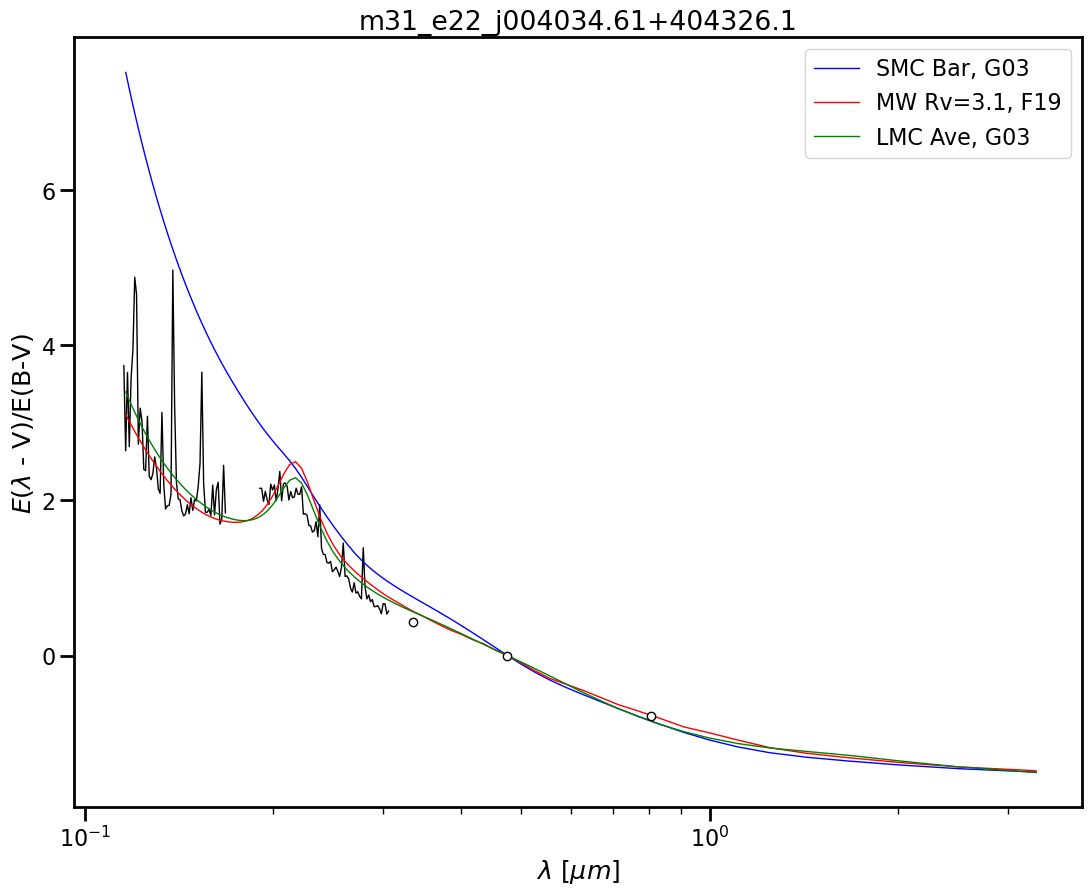

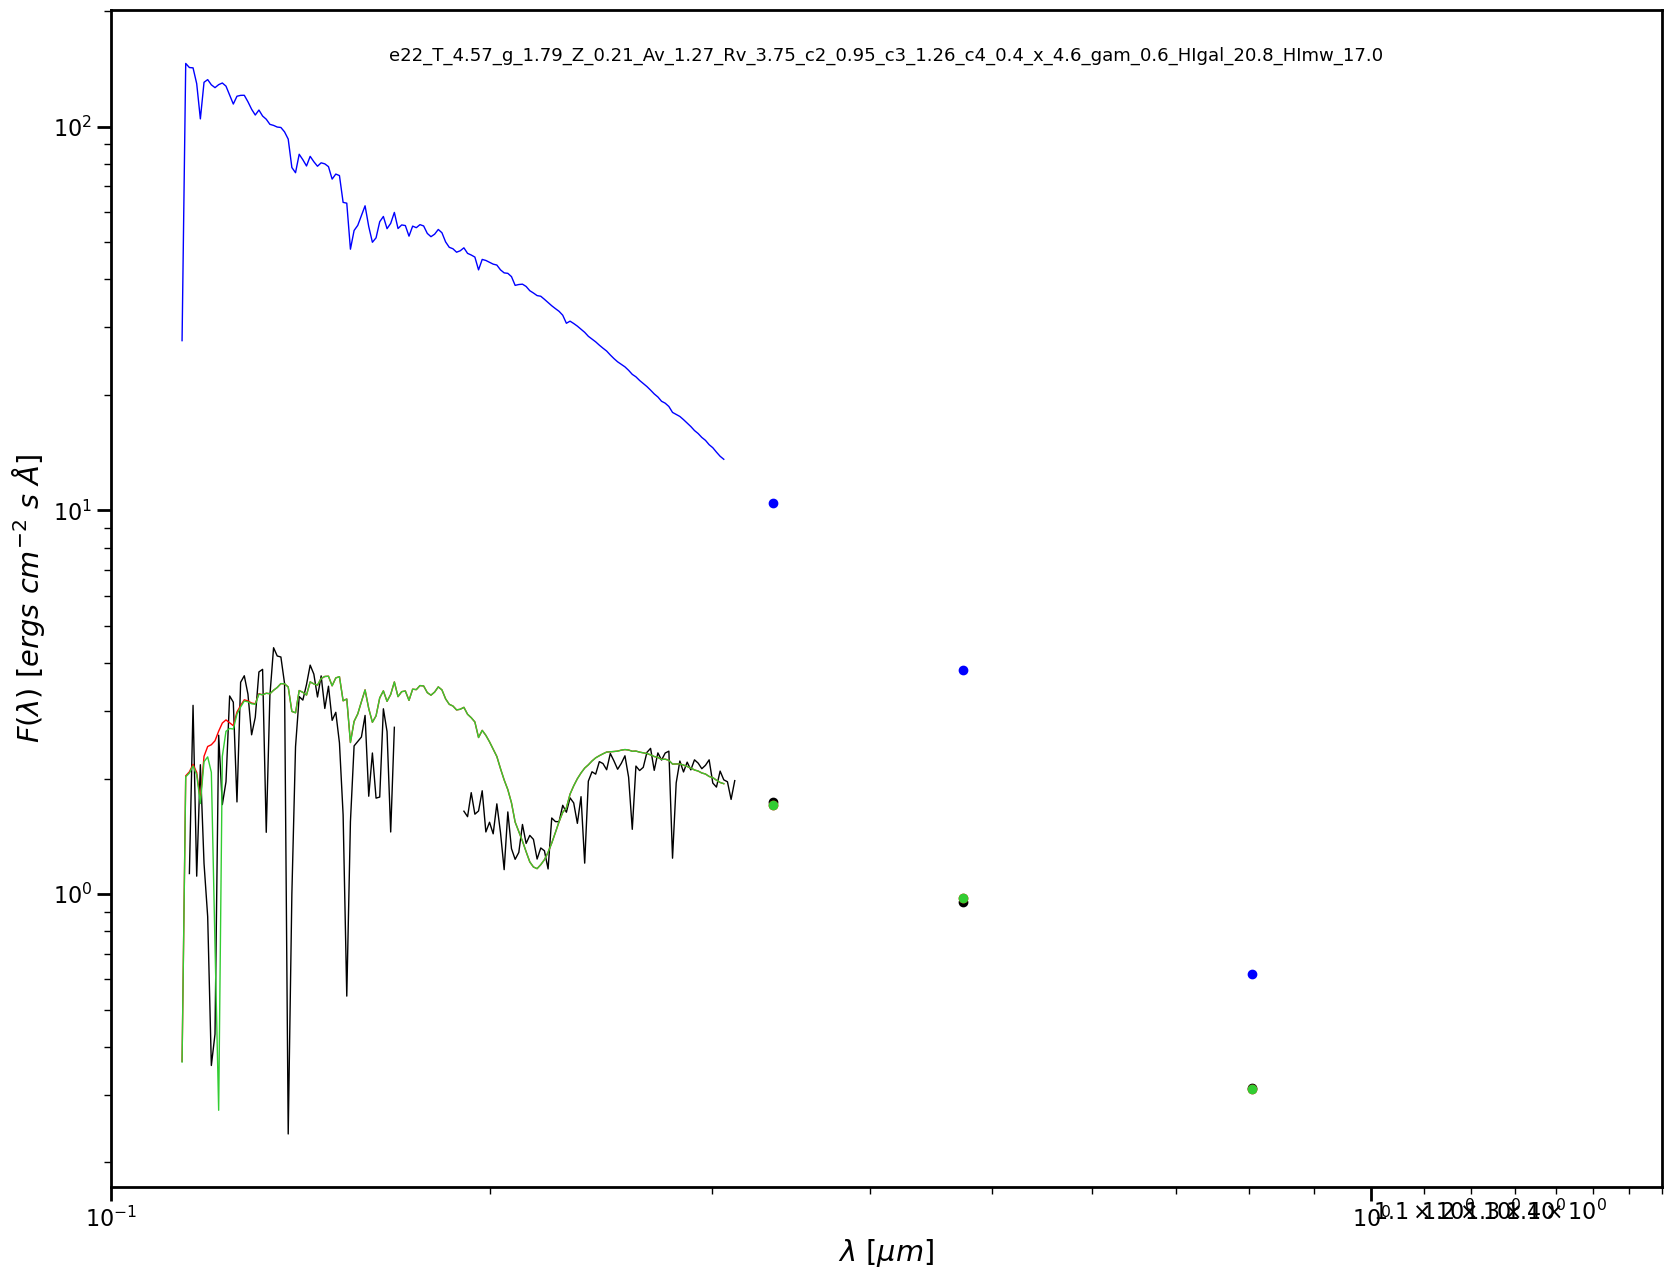

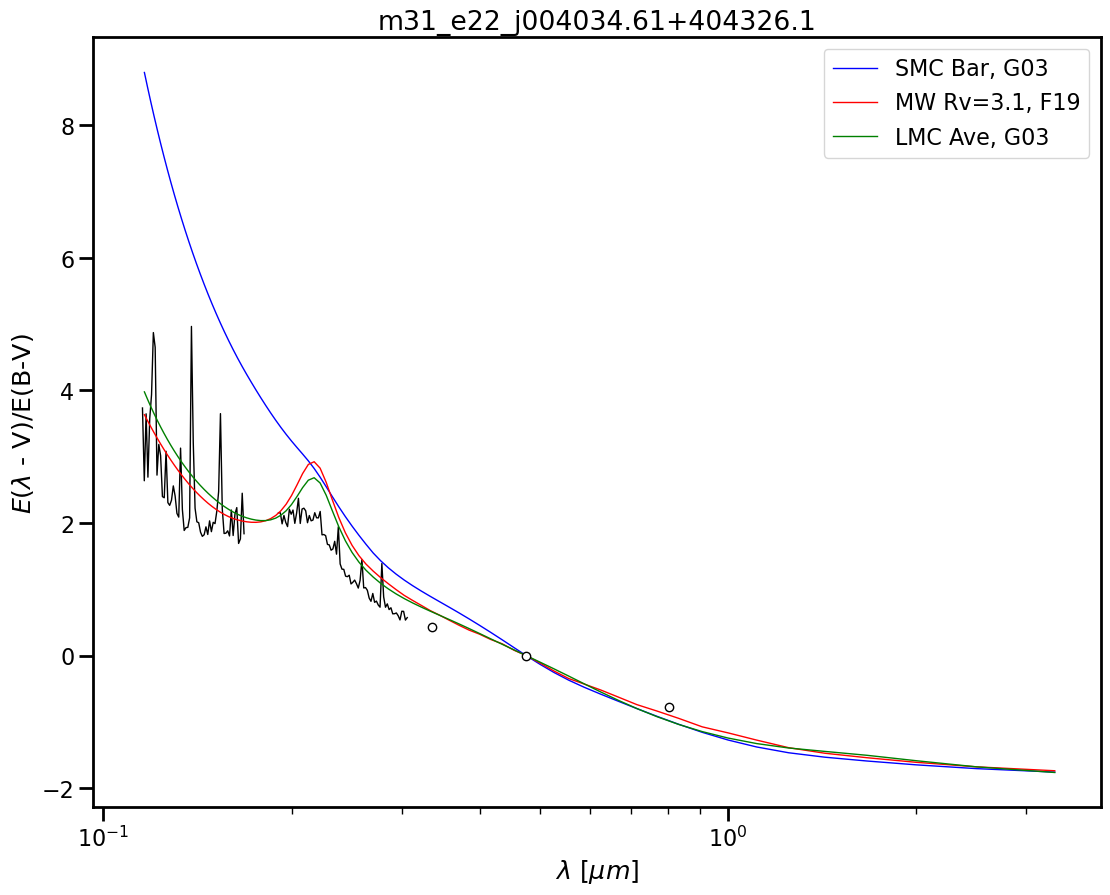

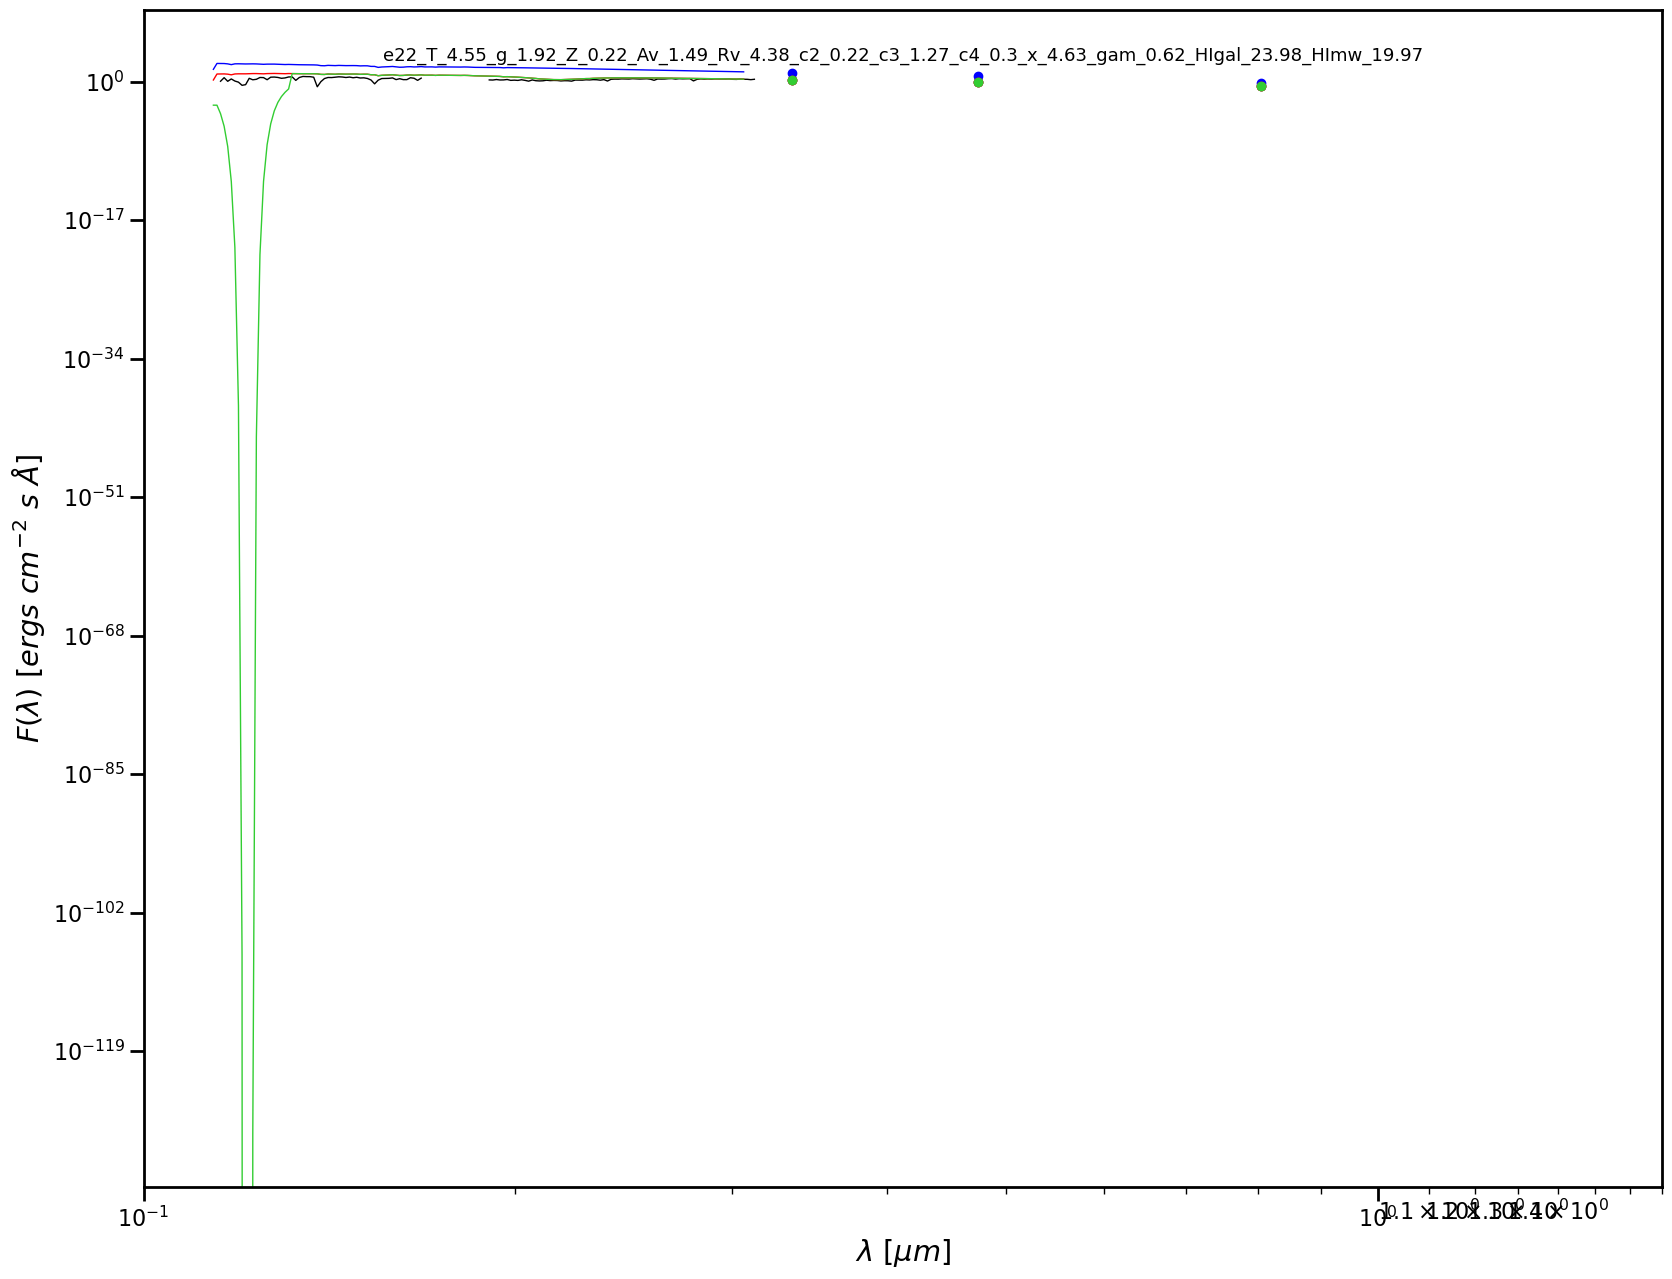

In [240]:
# Calculates all extinction curves
doall = True
singlevalued = True
save_ext_curve = True
plot_ext_curve = True

adjust_spectra = True
fourband = False

# If get_uncert is True, it runs the MCMC sampler
get_uncert = False
excl_wls = False

beg_wls = [.1141, .1155] #.1148]
end_wls = [.3130, .3155] #.3136, .3155

if doall:
    for i, s in enumerate(m31_list):
        print("Star", s)
        starname = m31_list[i]
        starstr = starname.split(gal_str)[1].split("_")[0]
        fstarname = f"{starname}.dat"
        
        if ('e22' in s) or ('e6' in s):
            print("getting models for 3-band photometry")
            fourband=True
        
        # Trim beg of spectrum with low flux
        if 'm31' in gal_str:
            if ('e9' in s) or ('e2' in s): # or ('e6' in s) or ('e22' in s):
                add_excl = [.113, .117] #.12
                print("Additional excl WLs:", add_excl)
            else:
                add_excl = None
            add_excl = None
        else:
            add_excl=False

        for j in range(len(m31_list)):
            if ('e22' in m31_list[j]) or ('e6' in m31_list[j]):
                print("getting models for 4-band photometry")
                fourband=True

        # Exclude regions specific to star
        if 'e12' in starstr:
            excl_wls = [.165, .205]
        elif 'e13' in starstr:
            excl_wls = [.165, .205]
        elif 'e14' in starstr:
            excl_wls = [.165, .21]
        elif 'e17' in starstr:
            excl_wls = [.185, .19]
        elif 'e18' in starstr:
            excl_wls = [.18, .2]
        elif 'e1' in starstr:
            excl_wls = [.18, .2]
        elif 'e4' in starstr:
            excl_wls = [.17, .2]
        elif 'e5' in starstr:
            excl_wls = [.18, .2]
        elif 'e7' in starstr:
            excl_wls = [.17, .19]
        elif 'e8' in starstr:
            excl_wls = [.165, .19]
        elif 'e22' in starstr:
            excl_wls = [.168, .19]
        else:
            excl_wls = False #[.1601, .1602] # excl_wls = [.17, .2]

        print('in run, excls wv', excl_wls)

        # Read in star data, by default 0 fluxes and fluxes in excl_wls are masked
        reddened_star, \
        band_names, \
        data_names, \
        gindxs, \
        excl_fluxes = get_red_star(fstarname, 
                                   file_path, 
                                   excl_zero=True,
                                   excl_wls=excl_wls, 
                                   fourband=fourband,
                                   nof275w=nof275w,
                                   beg_wls=beg_wls,
                                   end_wls=end_wls)

        # Adjust spectra
        if adjust_spectra:
            spec_adj = spec_corr(galaxy, starstr)
            reddened_star.data["STIS"].fluxes = (reddened_star.data["STIS"].fluxes.value * spec_adj) * (u.erg / ((u.cm ** 2) * u.s * u.angstrom))

        # Need to adjust spectra for e17, e18, e24
        for j in range(len(m31_list)):
            if ('e17' in m31_list[j]) or ('e18' in m31_list[j]) or ('e24' in m31_list[j]):
                spec_adj = spec_corr(galaxy, starstr)
                reddened_star.data["STIS"].fluxes = (reddened_star.data["STIS"].fluxes.value * spec_adj) * (u.erg / ((u.cm ** 2) * u.s * u.angstrom))

        # Remove negative fluxes
        (nvals,) = np.where(reddened_star.data["STIS"].fluxes.value < 0)
        reddened_star.data["STIS"].npts[nvals] = 0
        (nvals0,) = np.where(reddened_star.data["STIS"].fluxes.value == 0.)
        reddened_star.data["STIS"].npts[nvals0] = 0
        # print('len nvals for negative fluxes', len(np.where(nvals==True)))
        # print('len nvals for zero fluxes', len(np.where(nvals0==True)))

        reddened_star.data["STIS"].fluxes[reddened_star.data["STIS"].npts == 0] = np.nan

        # Rebin spectra
        reddened_star.data["STIS"].rebin_constres(rwaverange, gres)
        
        # Remove F275W
        # reddened_star.data["STIS"].rebin_constres(rwaverange, gres)


        # Set up parameter ranges; Relevant if testing initial values
        initial_grid, logtgrid, logggrid, logzgrid, \
        avgrid, rvgrid, \
        c2grid, c3grid, c4grid, \
        x0grid, gammagrid, \
        hi_galgrid, hi_mwgrid = setup_param_ranges(starname, starstr, small_vary=False)
        
        do_calc(reddened_star,
                gindxs, 
                excl_fluxes,
                reddened_star_a,
                initial_grid, 
                singlevalued, 
                excl_wls,
                get_uncert, 
                save_ext_curve,
                plot_ext_curve,
                )

# Plot FM parameters

In [54]:
print("galaxy", gal_str)
if 'm33' in gal_str:
    m31_list = ["m33_e1_j013334.26+303327", 
                 "m33_e2_j013339.52+304540",
                 "m33_e4_j013344.59+304436",  
                 "m33_e7_j012241.93+304728"]
elif 'm31' in gal_str:
    m31_list = [
        #"m31_e1_j004354.05+412626.0",
        "m31_e2_j004413.84+414903.9", "m31_e3_j004420.52+411751.1",
        "m31_e4_j004427.47+415150.0","m31_e5_j004431.66+413612.4",
        #"m31_e6_j004438.71+415553.5",
        "m31_e7_j004454.37+412823.9","m31_e8_j004511.82+415025.3","m31_e9_j004511.85+413712.9", 
        # "m31_e10_j004512.73+413726.4", # No STIS data, "m31_e11_j004535.40+414431.5", # No STIS data
        "m31_e12_j004539.00+415439.0","m31_e13_j004539.70+415054.8",
        "m31_e14_j004543.46+414513.6","m31_e15_j004546.81+415431.7",
            ]
# M31 FM90 params
# c2 = [1.182, 0.984, 1.259, 1.155, 0.842, 1.147, 0.665, 0.84, 1.06, 1.24, 1.36]
# c3 = [2.13, 1.212, 1.0975, 2.165, 1.37, 1.21, 1.88, 2.14, 2.31, 1.39, 1.89]
# c4 = [0.118, 0.117, 0.0242, 0.067, 0.019, 0.153, 0.241, 0.011, 0.01, 0.02, 0.05]
# x0 = [4.795, 4.627, 4.817, 4.724, 4.74, 4.7, 4.6, 4.78, 4.87, 4.88, 4.85]
# ebv = [0.333, 0.355, 0.3988, 0.386, 0.54, 0.43, 0.37, 0.48, 0.464, 0.53, 0.39]
# gamma [0.88, 0.6, 0.758, 0.944, 1.098, 0.677, 0.959, 0.862, 1.068, 0.604, 0.947]

    
    
# for i, star in enumerate(m31_list):
#     starstr = star.split(gal_str)[1].split("_")[0]
#     print("star", star)
#     print("starstr", starstr)

#     results_file = "params_dat/" + gal_str.split("_")[0] + "/" + starstr + "_fit_params.dat"

#     with open(results_file, 'r') as f:
#         x = [float(line.strip()) for line in lines if line]
#         print("x", x)
#         print("type x", type(x))
        
# #     with open(results_file, 'r') as f:
# #         lines = (line.strip() for line in f if line)
# #         print("lines", lines)
# #         x = [float(line) for line in lines]
# #         print("x", x)

#     resdata = np.fromfile(results_file, dtype="float", sep="\n")
#     print("resdata", resdata)
#     logt = [resdata[0]]
#     logg = [resdata[1]]
#     logz = [resdata[2]]
#     av = [resdata[3]]
#     rv = [resdata[4]]
#     c2 = [resdata[5]]
#     c3 = [resdata[6]]
#     c4 = [resdata[7]]
#     x0 = [resdata[8]]
#     gamma = [resdata[9]]
#     hi_gal = [resdata[10]]
#     hi_mwgrid = [resdata[11]]
#     hi_av = [resdata[12]]
#     hi_ebv = [resdata[13]]
    
#     print("star", star)
#     print("logt", logt)
#     print("logz", logz)

    #f = open("params_dat/" + gal_str.split("_")[0] + "/" + starstr + "_fit_params.dat", "r")
    
#     r = f.read()
#     for j in range(15):
#         print(j)
#         print(r[j])
    

# for k, val in enumerate(params_per):
#     f.read(
#         "{} {} {} {} # {}\n".format(
#            params_best[k], val[0], val[1], val[2], pnames_extra[k]
#         )
#     )

logt=[]; logtp50=[]; logtp1sig=[]; logtm1sig=[]
logg=[]; loggp50=[]; loggp1sig=[]; loggm1sig=[]
logz=[]; logzp50=[]; logzp1sig=[]; logzm1sig=[]
av=[]; avp50=[]; avp1sig=[]; avm1sig=[]
rv=[]; rvp50=[]; rvp1sig=[]; rvm1sig=[]
c2=[]; c2p50=[]; c2p1sig=[]; c2m1sig=[]
c3=[]; c3p50=[]; c3p1sig=[]; c3m1sig=[]
c4=[]; c4p50=[]; c4p1sig=[]; c4m1sig=[]
x0=[]; x0p50=[]; x0p1sig=[]; x0m1sig=[]
gamma=[]; gammap50=[]; gammap1sig=[]; gammam1sig=[]
higal=[]; higalp50=[]; higalp1sig=[]; higalm1sig=[]
himw=[]; himwp50=[]; himwp1sig=[]; himwm1sig=[]
p1=[];p2=[];p3=[];p4=[];p5=[];p6=[];p7=[];p8=[];p9=[];p10=[];p11=[];p12=[]

p = [p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12]

plt.figure(figsize=(20,15))

for i, star in enumerate(m31_list):
    starname = star
    starstr = starname.split(gal_str)[1].split("_")[0]
    results_file = "params_dat/" + gal_str.split("_")[0] + "/" + starstr + "_fit_params.dat"

    with open(results_file) as fin:
        data = (i for i in fin if not i.isspace())
#         print("data", data)
#         print(data[0])
        resdata = np.fromfile(results_file, dtype="float", sep="\n")
        j=0
        for row in data:
            p[j].append(row)
            print("row", row)
            print("type row", type(row))
            print("float(row[2])", float(row[2]))
            sig=(float(row[2]) - float(row[3]))/2
            print("sig", sig)
            j+=1
            if j < 7:
                row = next(data)

                
# plt.subplot(231)
# plt.subplot(232)
# plt.subplot(233)
# plt.subplot(234)
# plt.subplot(235)
# plt.subplot(236)

# plt.savefig(savefile_path + "fmparams/fm_1.png", bbox_inches='tight')

galaxy m31_
row 4.694151866692288 4.693642450493978 0.041914705021047105 0.00180619833925455 # logT

type row <class 'str'>
float(row[2]) 6.0
sig -1.5
row 0.09043416532084692 0.09095418484937859 0.0016587150419656999 0.021206892294348648 # logZ

type row <class 'str'>
float(row[2]) 0.0
sig -4.5
row 2.790973238918475 2.8129902531168383 0.02279568837659296 0.013486559222494865 # Rv

type row <class 'str'>
float(row[2]) 7.0
sig -1.0
row 2.1287680990476576 2.2380208483402697 0.08064768280370105 0.08539199842891021 # C3

type row <class 'str'>
float(row[2]) 1.0
sig -0.5
row 4.794502139223515 4.810343863197098 0.028429507455979497 0.013076391947438815 # x0

type row <class 'str'>
float(row[2]) 7.0
sig -1.0
row 17.001855226130626 17.30195360926112 0.4553675628288971 0.25469450433289964 # HI_gal

type row <class 'str'>


ValueError: could not convert string to float: '.'

<Figure size 1440x1080 with 0 Axes>

### Calc & save ext curve with new best fit params
#### (now fit_params = params; also params_best = params &  pnames_extra = pnames)

In [23]:
# intrinsic sed
modsed = modinfo_rb.stellar_sed(fit_params[0:3], velocity=velocity)

# dust_extinguished sed
ext_modsed = modinfo_rb.dust_extinguished_sed(fit_params[3:10], modsed)

# hi_abs sed
hi_ext_modsed = modinfo_rb.hi_abs_sed(
    fit_params[10:12], [velocity, 0.0], ext_modsed
)

# create a StarData object for the best fit SED
modsed_stardata = modinfo_rb.SED_to_StarData(modsed)

# create an extincion curve and save it
extdata = ExtData()
extdata.calc_elx(reddened_star, modsed_stardata, rel_band=relband)
col_info = {"av": fit_params[3], "rv": fit_params[4]}
extdata.save("extcurves/" + starstr + "_ext2.fits", column_info=col_info)

NameError: name 'fit_params' is not defined

### Plot new best-fit model spectra

In [21]:
def plot_new_bf_spectra(hi_ext_modsed, reddened_star):
    """
    """""
    norm_model = np.average(hi_ext_modsed["BAND"])
    norm_data = np.average(reddened_star.data["BAND"].fluxes)

    # plotting setup for easier to read plots
    fontsize = 16
    font = {"size": fontsize}
    mpl.rc("font", **font)
    mpl.rc("lines", linewidth=1)
    mpl.rc("axes", linewidth=2)
    mpl.rc("xtick.major", width=2)
    mpl.rc("xtick.minor", width=2)
    mpl.rc("ytick.major", width=2)
    mpl.rc("ytick.minor", width=2)

    # setup the plot
    fig, ax = plt.subplots(figsize=(13, 9.5))

    # plot the bands and all spectra for this star
    for cspec in modinfo.fluxes.keys():
        if cspec == "BAND":
            ptype = "o"
        else:
            ptype = "-"

        # ax.plot(reddened_star.data[cspec].waves,
        #        weights[cspec], 'k-')

        ax.plot(
            reddened_star.data[cspec].waves,
            reddened_star.data[cspec].fluxes / norm_data,
            "k" + ptype,
            label="data",
        )

        # print(reddened_star.data[cspec].waves)
        # print(modinfo.waves[cspec])

        ax.plot(
            modinfo.waves[cspec], modsed[cspec] / norm_model, "b" + ptype, label=cspec
        )
        ax.plot(
            modinfo.waves[cspec],
            ext_modsed[cspec] / norm_model,
            "r" + ptype,
            label=cspec,
        )
        ax.plot(
            modinfo.waves[cspec],
            hi_ext_modsed[cspec] / norm_model,
            "g" + ptype,
            label=cspec,
        )

    # finish configuring the plot
    ax.set_ylim(8e4 / norm_model, 6e9 / norm_model)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
    ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
    ax.tick_params("both", length=10, width=2, which="major")
    ax.tick_params("both", length=5, width=1, which="minor")

    # ax.legend()

    # use the whitespace better
    # fig.tight_layout()
    plt.title(starname)
    plt.savefig(savefile_path + starstr + "_spectra2" + ".png")

NameError: name 'hi_ext_modsed' is not defined

### Plot new best-fit extinction curve

True


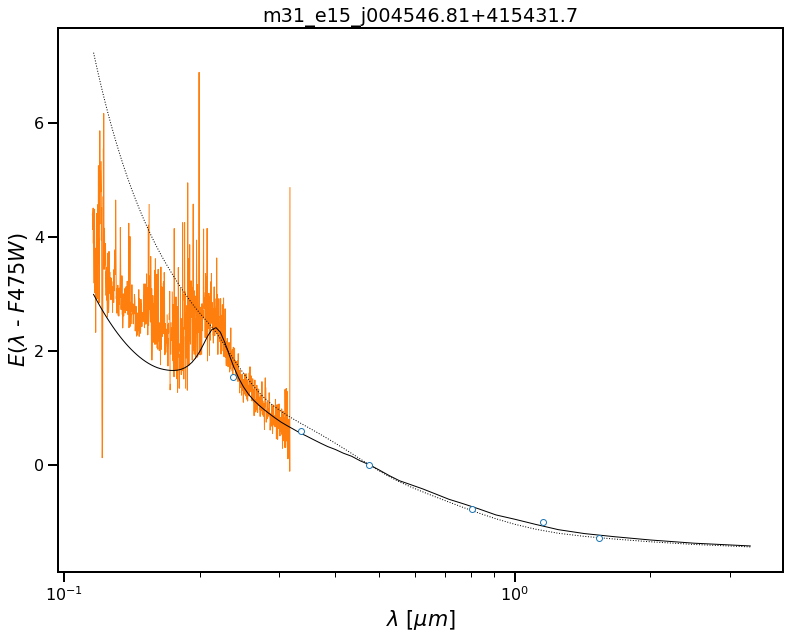

In [168]:
fig, ax = plt.subplots(figsize=(13, 10))

# convert from E(l-V) to A(l)/A(V)
print(extdata.type_rel_band != "V")
extdata.columns["AV"] = (params[3], 0.0)
# extdata.trans_elv_alav()

# def trans_elv_elvebv
extdata.plot(ax) #, alax=True)
ax.set_xscale("log")
ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
#ax.set_ylim(0.0, 10.0)
# ax.set_ylabel(r"$A(\lambda)/A(V)$", fontsize=1.3 * fontsize)
ax.set_ylabel(fr"$E(\lambda$ - %s)" % relband_str, fontsize=1.3 * fontsize)
ax.tick_params("both", length=10, width=2, which="major")
ax.tick_params("both", length=5, width=1, which="minor")

# plot known exitnction curves
mod_x = np.arange(0.3, 8.7, 0.1) / u.micron
smcbar = G03_SMCBar()
# ax.plot(1.0 / mod_x, smcbar(mod_x), "k:")
Af475wAv = smcbar(0.475 * u.micron)
smcbar_el475w = (smcbar(mod_x) - Af475wAv) * params[3]
ax.plot(1.0 / mod_x, smcbar_el475w, "k:")

f19_rv31 = F19(Rv=3.1)
# ax.plot(1.0 / mod_x, f19_rv31(mod_x), "k-")
# ax.set_xlim(0, 7.5)
Af475wAv = f19_rv31(0.475 * u.micron)
f19_el475w = (f19_rv31(mod_x) - Af475wAv) * params[3]
ax.plot(1.0 / mod_x, f19_el475w, "k-")
plt.title(starname)
plt.savefig(savefile_path + starstr + "_extcurve2" + ".png")


### Plot new spectra function 

In [284]:
def plot_spectra_with_mod(modinfo, hi_ext_modsed, reddened_star, modsed, ext_modsed, \
                          modsed_stardata, starstr, params, initial_grid):
    """
    """
    norm_model = np.average(hi_ext_modsed["BAND"])
    norm_data = np.average(reddened_star.data["BAND"].fluxes)

    # plotting setup for easier to read plots
    fontsize = 16
    font = {"size": fontsize}
    mpl.rc("font", **font)
    mpl.rc("lines", linewidth=1)
    mpl.rc("axes", linewidth=2)
    mpl.rc("xtick.major", width=2)
    mpl.rc("xtick.minor", width=2)
    mpl.rc("ytick.major", width=2)
    mpl.rc("ytick.minor", width=2)

    # setup the plot
    fig, ax = plt.subplots(figsize=(14, 12))

    # plot the bands and all spectra for this star
    for cspec in modinfo.fluxes.keys():
        if cspec == "BAND":
            ptype = "o"
        else:
            ptype = "-"

        # ax.plot(reddened_star.data[cspec].waves, weights[cspec], 'k-')

        # Observations
        ax.plot(
            reddened_star.data[cspec].waves,
            reddened_star.data[cspec].fluxes / norm_data,
            "k" + ptype,
            label="data",
        )

        # Intrinsic SED
#         print("test rebinned intrinsic wavelengths", modinfo.waves[cspec])
#         print("test rebinned intrinsic fluxes", modsed[cspec] / norm_model)
        ax.plot(
            modinfo.waves[cspec], 
            modsed[cspec] / norm_model, 
            "b" + ptype, label=cspec
        )
        
        # dust_extinguished sed
        ax.plot(
            modinfo.waves[cspec],
            ext_modsed[cspec] / norm_model,
            "r" + ptype,
            label=cspec,
        )
        
        # h(i) abs sed
        ax.plot(
            modinfo.waves[cspec],
            hi_ext_modsed[cspec] / norm_model,
            "g" + ptype,
            label=cspec,
        )

    # finish configuring the plot
#     ax.set_ylim(8e4 / norm_model, 6e9 / norm_model)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
    ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
    ax.tick_params("both", length=10, width=2, which="major")
    ax.tick_params("both", length=5, width=1, which="minor")

    # ax.legend()

    # use the whitespace better
    fig.tight_layout()
    
    # pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4",
    #"x0","gamma","HI_gal","HI_mw"]

    logt_round = np.around(params[0], decimals=2)
    logg_round = np.around(params[1], decimals=2)
    logz_round = np.around(params[2], decimals=2)
    av_round = np.around(params[3], decimals=2)
    rv_round = np.around(params[4], decimals=2)
    c2_round = np.around(params[5], decimals=2)
    c3_round = np.around(params[6], decimals=2)
    c4_round = np.around(params[7], decimals=2)
    x0_round = np.around(params[8], decimals=2)
    g_round = np.around(params[9], decimals=2)
    higal_round = np.around(params[10], decimals=2)
    himw_round = np.around(params[11], decimals=2)
    print("Fig params are log(T)=%s, log(g)=%s, Av=%s" % (params[0], params[1], params[3]))
    
    # Generate a name to record the star and its parameters
    param_combo_str = "_T_" + str(logt_round)  + "_g_" + str(logg_round) + \
                "_Z_" + str(logz_round) + \
                "_Av_"  + str(av_round) + "_Rv_" + str(rv_round) + "_c2_" + \
                str(c2_round) + "_c3_" + str(c3_round) + "_c4_" + str(c4_round) + "_x_" + \
                str(x0_round) + "_gam_" + str(g_round) + \
                "_HIgal_" + str(higal_round) + "_HImw_" + str(himw_round)
    
#     ax.set_title(starstr + param_combo_str, y=0.95, fontsize=13)
    
    # Title with initial value for initial pos
    param_combo_str_init = "_T_" + str(initial_grid[0][0])  + "_g_" + str(initial_grid[1][0]) + \
                "_Z_" + str(initial_grid[2][0]) + \
                "_Av_"  + str(initial_grid[3][0]) + "_Rv_" + str(initial_grid[4][0]) + "_c2_" + \
                str(initial_grid[5][0]) + "_c3_" + str(initial_grid[6][0]) + "_c4_" + str(initial_grid[7][0]) + "_x_" + \
                str(initial_grid[8][0]) + "_gam_" + str(initial_grid[9][0]) + \
                "_HIgal_" + str(initial_grid[10][0]) + "_HImw_" + str(initial_grid[11][0])

    # Set title to updated initial position, param_combo_str
    ax.set_title(starstr + param_combo_str, y=0.95, fontsize=15)
    
    if 'e6' in fstarname:
        ax.set_xlim(0.1, 1)
#     elif 'e2' in fstarname:
    ax.set_ylim(0.01, 250)

#     plt.savefig(savefile_path + "spectra_w_mod/" + starstr + "_rb_" +  str(gres) + "_res.png")
    plt.savefig(savefile_path + "starting_positions_retry/" + str(starstr) + "/" + starstr + "_rb_" +  \
                str(gres) + param_combo_str + ".png")
    print("Saved spectra w mod")

## Plot ext curve param results (put at end)

In [118]:
m31_results = [
    #"m31_e1_j004354.05+412626.0", # Prob. w sorting by UV slope; bad fit, no uncert. results
    "m31_e2_j004413.84+414903.9",
#     "m31_e3_j004420.52+411751.1",
#     "m31_e4_j004427.47+415150.0",
#     "m31_e5_j004431.66+413612.4",
#     "m31_e6_j004438.71+415553.5", # bad fit, no uncert. results
#     "m31_e7_j004454.37+412823.9",
#     "m31_e8_j004511.82+415025.3",
#     "m31_e9_j004511.85+413712.9", # some problem with walkers
#     "m31_e12_j004539.00+415439.0",
#     "m31_e13_j004539.70+415054.8",
#     "m31_e14_j004543.46+414513.6", # Prob. w sorting by UV slope
#     "m31_e15_j004546.81+415431.7",
]

# best fit, p50, p50 + 1sig, p50 - 1sig
logt=[]; logtp50=[]; logtp1sig=[]; logtm1sig=[]
logg=[]; loggp50=[]; loggp1sig=[]; loggm1sig=[]
logz=[]; logzp50=[]; logzp1sig=[]; logzm1sig=[]
av=[]; avp50=[]; avp1sig=[]; avm1sig=[]
rv=[]; rvp50=[]; rvp1sig=[]; rvm1sig=[]
c2=[]; c2p50=[]; c2p1sig=[]; c2m1sig=[]
c3=[]; c3p50=[]; c3p1sig=[]; c3m1sig=[]
c4=[]; c4p50=[]; c4p1sig=[]; c4m1sig=[]
x0=[]; x0p50=[]; x0p1sig=[]; x0m1sig=[]
gamma=[]; gammap50=[]; gammap1sig=[]; gammam1sig=[]
higal=[]; higalp50=[]; higalp1sig=[]; higalm1sig=[]
himw=[]; himwp50=[]; himwp1sig=[]; himwm1sig=[]
p1=[];p2=[];p3=[];p4=[];p5=[];p6=[];p7=[];p8=[];p9=[];p10=[];p11=[];p12=[]

p = [p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12]
# for k, val in enumerate(params_per):
#     f.write(
#         "{} {} {} {} # {}\n".format(
#            params_best[k], val[0], val[1], val[2], pnames_extra[k]
#         )
#     )
#f.write("# best fit, p50, +unc, -unc\n")

# Read in fit values
for i, star in enumerate(m31_results):
    starname = star
    starstr = starname.split(gal_str)[1].split("_")[0]
    results_file = "params_dat/" + starstr + "_fit_params.dat"

    with open(results_file) as fin:
        data = (i for i in fin if not i.isspace())
        print("data", data)
        j=0
        for row in data:
            p[j].append(row)
            print(row)
            j+=1
            if j < 7:
                row = next(data)

    print(p)
#     
#     ipdata = np.fromfile(results_file, dtype="float", sep="\n")
#     print(ipdata)
#     logg.append([ipdata[1]])
#     logz.append([ipdata[2]])
#     av.append([ipdata[3]])
#     rv.append([ipdata[4]])
#     c2.append([ipdata[5]])
#     c3.append([ipdata[6]])
#     c4.append([ipdata[7]])
#     x0.append([ipdata[8]])
#     gamma.append([ipdata[9]])
#     HI_gal.append([ipdata[10]])
#     HI_mw.append([ipdata[11]])

data <generator object <genexpr> at 0x7fe5d4b1e450>
4.740334323488035 4.720856487354006 0.013529512828514889 0.0624197943401521 # logT

0.12215133428859155 0.09814391806892488 0.024976488195594365 0.015346901345937775 # logZ

2.7882822368557316 2.785400311391983 0.013110457907309137 0.08745751605367857 # Rv

1.3706544827143778 1.4854677806800254 0.4242025430187235 0.09459494574376204 # C3

4.706031216614668 4.703716160298124 0.009524804283738142 0.02232121690192912 # x0

17.214366297626526 17.74036796872021 4.1065032768429255 0.65625008504637 # HI_gal

0.3339587616706861 0.3228745786632307 0.011338121862540296 0.010367198172903713 # E(B-V)

1.759287121735708e+17 6.018784288322455e+17 8.346946299972925e+21 4.69694982431252e+17 # N(HI)/A(V)

4.905389031064722e+17 1.675897632975754e+18 2.2585297291353086e+22 1.3070545041231828e+18 # N(HI)/E(B-V)
[['4.740334323488035 4.720856487354006 0.013529512828514889 0.0624197943401521 # logT\n'], ['0.12215133428859155 0.09814391806892488 0.0249764881